## Transformerによる極値予測

## step1

In [1]:
# Step 1: 環境セットアップ（Google Driveマウント＋ライブラリインポート）
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Drive mount skipped")
import math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, f1_score

Drive mount skipped


## step2

In [2]:
# Step 2: ファイルパス定義
# TRAIN_PATH = "/content/drive/MyDrive/TSAT/BTC_5min/BTC_full_5min_Train.csv"
# VALID_PATH = "/content/drive/MyDrive/TSAT/BTC_5min/BTC_full_5min_Valid.csv"

TRAIN_PATH = "/home/nagumo/TSAT/BTC_5min/BTC_full_5min_Train.csv"
VALID_PATH = "/home/nagumo/TSAT/BTC_5min/BTC_full_5min_Valid.csv"

## step3

In [3]:
# Step 3: 再現性確保のためのシード固定
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## step4

In [4]:
# Step 4: データ読み込み＆補間関数定義
def load_and_interpolate(path):
    df = pd.read_csv(path, parse_dates=['date']).set_index('date').sort_index()
    idx = pd.date_range(df.index.min(), df.index.max(), freq='5T')
    return df.reindex(idx).interpolate(method='time')


## step5

In [5]:
# Step 5: データ読み込み実行＋期間フィルタリング
df_train = load_and_interpolate(TRAIN_PATH)
df_valid = load_and_interpolate(VALID_PATH)
df_train = df_train[df_train.index >= '2020-01-01']
print("Train:", df_train.index.min(), "to", df_train.index.max())
print("Valid:", df_valid.index.min(), "to", df_valid.index.max())

Train: 2020-01-01 00:00:00 to 2022-12-31 23:55:00
Valid: 2023-01-01 00:00:00 to 2023-12-14 23:55:00


In [6]:
# Step 5: ハードラベル生成 (前後 k=6)
def make_hard_labels(lows, highs, k=6):
    n = len(lows)
    lbl = np.zeros(n, dtype=int)
    for t in range(k, n-k):
        if lows[t] < lows[t-k:t].min() and lows[t] < lows[t+1:t+k+1].min():
            lbl[t] = 1
        elif highs[t] > highs[t-k:t].max() and highs[t] > highs[t+1:t+k+1].max():
            lbl[t] = 2
    return lbl

lows_train, highs_train = df_train['low'].values, df_train['high'].values
lows_val, highs_val     = df_valid['low'].values, df_valid['high'].values
hard_train = make_hard_labels(lows_train, highs_train, k=6)
hard_val   = make_hard_labels(lows_val, highs_val, k=6)
df_train['hard_label'] = hard_train
df_valid['hard_label'] = hard_val

## step6

In [7]:
# Step 6: スコアベースソフトラベリング関数
def compute_scores(lows, highs, k=6):
    n = len(lows)
    s_min = np.zeros(n)
    s_max = np.zeros(n)
    for t in range(k, n-k):
        # 極小度
        s_min[t] = 100*np.mean((lows[t-k:t] - lows[t]) / lows[t-k:t] +
                           (lows[t+1:t+k+1] - lows[t]) / lows[t+1:t+k+1])
        # 極大度
        s_max[t] = 100*np.mean((highs[t] - highs[t-k:t]) / highs[t-k:t] +
                           (highs[t] - highs[t+1:t+k+1]) / highs[t+1:t+k+1])
    return s_min, s_max

smin_train, smax_train = compute_scores(lows_train, highs_train, k=6)
smin_val, smax_val     = compute_scores(lows_val, highs_val, k=6)

def soft_label_from_scores(smin, smax):
    # baseline for Other = 1.0
    # logits = np.stack([np.ones_like(smin), smin, smax], axis=1)
    logits = np.stack([1.5-np.maximum(smin, smax), smin, smax], axis=1) # other をsmin-smax
    exp = np.exp(logits)
    return exp / exp.sum(axis=1, keepdims=True)

soft_train = soft_label_from_scores(smin_train, smax_train)
soft_val   = soft_label_from_scores(smin_val, smax_val)
df_train['soft_label'] = list(soft_train)
df_valid['soft_label'] = list(soft_val)

In [51]:
df_train

,open,high,low,close,volume,hard_label,soft_label
2020-01-01 00:00:00,7165.720,7208.200,7151.92,7155.000,70.7630,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."
2020-01-01 00:05:00,7156.520,7201.700,7136.05,7161.730,130.2290,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."
2020-01-01 00:10:00,7163.620,7203.900,7156.63,7158.230,17.1900,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."
2020-01-01 00:15:00,7182.780,7198.400,7152.25,7190.276,44.0970,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."
2020-01-01 00:20:00,7190.276,7197.676,7151.60,7154.480,44.5350,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."
...,...,...,...,...,...,...,...
2022-12-31 23:35:00,16529.410,16573.000,16519.90,16535.960,146.5723,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."
2022-12-31 23:40:00,16534.420,16576.000,16528.00,16536.930,87.8290,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."
2022-12-31 23:45:00,16536.930,16576.000,16527.70,16528.450,154.5496,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."
2022-12-31 23:50:00,16529.920,16568.000,16521.70,16529.010,70.3992,0,"[0.6914384540362276, 0.15428077298188622, 0.15..."


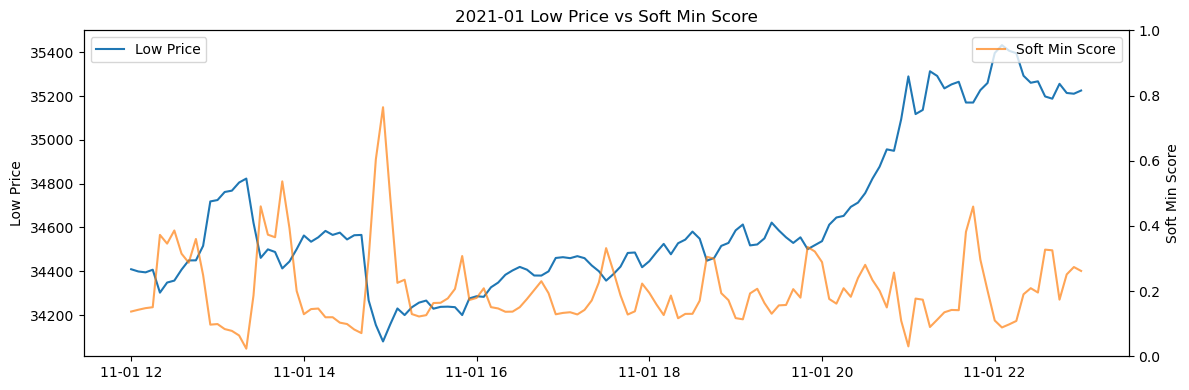

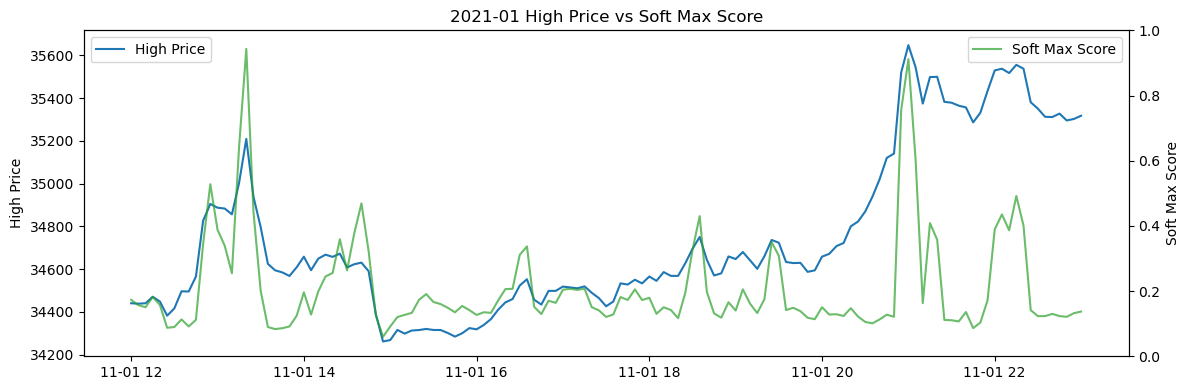

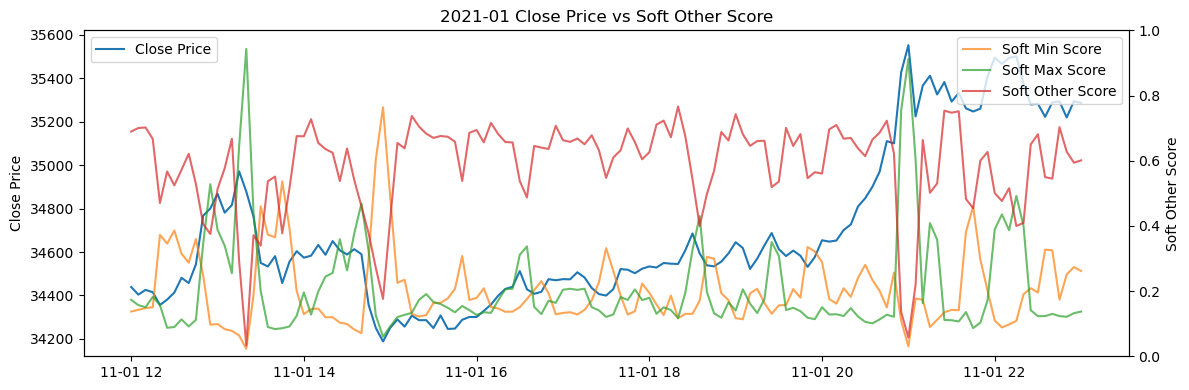

In [48]:
# ソフトラベリングの結果を確認

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- ソフトラベルを numpy array に展開 ---
soft_array = np.array(df_valid['soft_label'].tolist())
soft_other = soft_array[:, 0]
soft_min   = soft_array[:, 1]
soft_max   = soft_array[:, 2]

# --- タイムインデックスと価格 ---
times       = df_valid.index
low_series  = df_valid['low']
high_series = df_valid['high']
close_series = df_valid['close']

# --- プロット範囲を 2021-01-01 ～ 2021-01-31 に限定 ---
start, end = pd.to_datetime("2023-11-01-12:00:00"), pd.to_datetime("2023-11-01-23:00:00")
mask = (times >= start) & (times <= end)

# --- 抽出 ---
times_f        = times[mask]
low_f          = low_series[mask]
high_f         = high_series[mask]
close_f       = close_series[mask]
soft_min_f     = soft_min[mask]
soft_max_f     = soft_max[mask]
soft_other_f   = soft_other[mask]

# --- プロット1: Low Price vs Soft Min Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, low_f, label='Low Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_min_f, label='Soft Min Score', color='tab:orange', alpha=0.7)
ax2.set_ylim(0,1)
ax1.set_title('2021-01 Low Price vs Soft Min Score')
ax1.set_ylabel('Low Price')
ax2.set_ylabel('Soft Min Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --- プロット2: High Price vs Soft Max Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, high_f, label='High Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_max_f, label='Soft Max Score', color='tab:green', alpha=0.7)
ax2.set_ylim(0,1)
ax1.set_title('2021-01 High Price vs Soft Max Score')
ax1.set_ylabel('High Price')
ax2.set_ylabel('Soft Max Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --- プロット3: Close vs Soft Other Score ---
fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(times_f, close_f, label='Close Price', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(times_f, soft_min_f, label='Soft Min Score', color='tab:orange', alpha=0.7)
ax2.plot(times_f, soft_max_f,label='Soft Max Score', color='tab:green', alpha=0.7)
ax2.plot(times_f, soft_other_f, label='Soft Other Score', color='tab:red', alpha=0.7)
ax2.set_ylim(0,1)
ax1.set_title('2021-01 Close Price vs Soft Other Score')
ax1.set_ylabel('Close Price')
ax2.set_ylabel('Soft Other Score')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


## step7

In [8]:
# Step 7: シーケンス特徴量 & ラベル生成 (SEQ_LEN=288)
SEQ_LEN = 288
from sklearn.model_selection import train_test_split
import os
import numpy as np
from tqdm import tqdm # tqdmライブラリをインポート (通常はスクリプトの先頭(Step1等)で一度だけインポートします)

output_dir = "evaluation_results"
os.makedirs(output_dir, exist_ok=True)

def make_dataset(df, hard_lbl, soft_lbl, description="Creating dataset"):
    """
    DataFrameからシーケンス特徴量とラベルを生成します。
    処理の進捗はtqdmプログレスバーで表示されます。
a
    Args:
        df (pd.DataFrame): 入力DataFrame (価格データなどを含む)
        hard_lbl (np.array): ハードラベル配列
        soft_lbl (np.array): ソフトラベル配列
        description (str, optional): tqdmプログレスバーに表示する説明文. Defaults to "Creating dataset".

    Returns:
        tuple: X, y_hard, y_soft, y_reg, t_indices のnumpy配列を含むタプル
    """
    X, y_hard, y_soft, y_reg, t_indices = [], [], [], [], []
    
    # DataFrameの行数に基づいてイテレーション。tqdmで進捗を表示。
    # unit="sequences" は進捗バーの単位がシーケンスであることを示す。
    # leave=True (デフォルト) はループ終了後もプログレスバーを残す。
    for t in tqdm(range(SEQ_LEN-1, len(df)-6), desc=description, unit="sequences", leave=True):
        win = df.iloc[t-SEQ_LEN+1:t+1]
        
        # --- 特徴量生成 ---
        c0 = win['close'].iloc[-1] 
        v0 = win['volume'].iloc[-1]

        norm_close = win['close'] / c0
        norm_high = win['high'] / c0
        norm_low = win['low'] / c0
        
        if v0 != 0:
            normalized_volume = win['volume'] / v0
        else:
            normalized_volume = np.zeros_like(win['volume'], dtype=float) 
        
        feats = np.stack([norm_close,
                          norm_high,
                          norm_low,
                          normalized_volume], axis=1)
        X.append(feats)
        
        # --- ラベル生成 ---
        y_hard.append(hard_lbl[t])
        y_soft.append(soft_lbl[t])
        
        if t + 1 < len(df): 
            c_plus_1 = df['close'].iloc[t+1]
            if c0 != 0:
                reg_target = c_plus_1 / c0
            else:
                reg_target = 1.0 
        else:
            reg_target = 1.0
        y_reg.append(reg_target)
        
        t_indices.append(t) 
        
    return np.array(X, dtype=np.float32), \
           np.array(y_hard), \
           np.array(y_soft, dtype=np.float32), \
           np.array(y_reg, dtype=np.float32), \
           np.array(t_indices)

# --- データセット作成実行 ---
# make_dataset呼び出し時に、tqdmプログレスバー用の説明文を指定
print("--- Training data creation ---")
X_tr, y_tr_hard, y_tr_soft, y_tr_reg, t_tr_indices = make_dataset(
    df_train, hard_train, soft_train, description="Processing df_train"
)
print("\n--- Validation/Test data creation ---")
X_val_all, y_val_hard_all, y_val_soft_all, y_val_reg_all, t_val_all_indices = make_dataset(
    df_valid, hard_val, soft_val, description="Processing df_valid"
)
print("") # tqdmの表示とprint文の間にスペースを空ける

# --- 検証データとテストデータの分割 ---
if len(X_val_all) > 1:
    X_val, X_test, \
    y_val_hard, y_test_hard, \
    y_val_soft, y_test_soft, \
    y_val_reg, y_test_reg, \
    t_val_indices, t_test_indices = train_test_split(
        X_val_all, y_val_hard_all, y_val_soft_all, y_val_reg_all, t_val_all_indices,
        test_size=0.5, random_state=SEED, shuffle=True # SEEDは事前に定義されている前提
    )
else:
    print("Warning: Not enough data in df_valid to split into validation and test sets after make_dataset. Using all for validation and test if applicable.")
    X_val, y_val_hard, y_val_soft, y_val_reg, t_val_indices = X_val_all, y_val_hard_all, y_val_soft_all, y_val_reg_all, t_val_all_indices
    X_test, y_test_hard, y_test_soft, y_test_reg, t_test_indices = X_val_all, y_val_hard_all, y_val_soft_all, y_val_reg_all, t_val_all_indices

# --- データ形状の確認表示 ---
print(f"X_tr shape: {X_tr.shape}, y_tr_reg shape: {y_tr_reg.shape}")
print(f"X_val shape: {X_val.shape if len(X_val)>0 else 'N/A'}, y_val_reg shape: {y_val_reg.shape if len(X_val)>0 else 'N/A'}")
print(f"X_test shape: {X_test.shape if len(X_test)>0 else 'N/A'}, y_test_reg shape: {y_test_reg.shape if len(X_test)>0 else 'N/A'}")

--- Training data creation ---


Processing df_train: 100%|██████████| 315355/315355 [02:34<00:00, 2034.72sequences/s]



--- Validation/Test data creation ---


Processing df_valid: 100%|██████████| 99931/99931 [00:44<00:00, 2223.56sequences/s]



X_tr shape: (315355, 288, 4), y_tr_reg shape: (315355,)
X_val shape: (49965, 288, 4), y_val_reg shape: (49965,)
X_test shape: (49966, 288, 4), y_test_reg shape: (49966,)


## step8

In [9]:
# Step 8: Dataset & DataLoader
class BTCSeqDataset(Dataset):
    def __init__(self, X, y_hard, y_soft, y_reg, t_indices): # y_reg を追加
        self.X = torch.from_numpy(X)
        self.y_hard = torch.from_numpy(y_hard)
        self.y_soft = torch.from_numpy(y_soft)
        self.y_reg = torch.from_numpy(y_reg) # y_reg を torch tensor に変換
        self.t_indices = torch.from_numpy(t_indices)

    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y_hard[i], self.y_soft[i], self.y_reg[i], self.t_indices[i] # y_reg を返す

BATCH = 64
dl_tr = DataLoader(BTCSeqDataset(X_tr, y_tr_hard, y_tr_soft, y_tr_reg, t_tr_indices), batch_size=BATCH, shuffle=True)

if len(X_val) > 0 :
    dl_val = DataLoader(BTCSeqDataset(X_val, y_val_hard, y_val_soft, y_val_reg, t_val_indices), batch_size=BATCH)
else:
    dl_val = None
    print("Validation DataLoader (dl_val) is not created due to empty X_val.")

if len(X_test) > 0:
    dl_test= DataLoader(BTCSeqDataset(X_test, y_test_hard, y_test_soft, y_test_reg, t_test_indices), batch_size=BATCH)
else:
    dl_test = None
    print("Test DataLoader (dl_test) is not created due to empty X_test.")

## step9

In [56]:
# Step 9: PositionalEncoding + TransformerClassifier with SoftLabel Loss
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000)/d_model))
        pe[:,0::2] = torch.sin(pos * div)
        pe[:,1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x): return x + self.pe[:x.size(0)]

class TransformerClassifierSoftLabel(nn.Module):
    def __init__(self, d_model=120, nhead=3, num_layers=2, num_classes=3, lambda_reg=0.1):
        super().__init__()
        self.lambda_reg = lambda_reg
        self.proj = nn.Linear(4, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        layer = nn.TransformerEncoderLayer(d_model, nhead=nhead, dim_feedforward=256)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.classifier = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))
        self.regressor  = nn.Linear(d_model, 1)

    def forward(self, x):
        h = self.proj(x).permute(1,0,2)
        h = self.pos_enc(h)
        h = self.encoder(h)
        cls = h[-1]
        return self.classifier(cls), self.regressor(cls).squeeze(-1)

    def compute_loss(self, logits, y_hard, y_soft, reg, y_reg):
        # 分類損失: KLDiv between softmax(logits) & soft labels
        loss_cls = F.kl_div(F.log_softmax(logits, dim=-1), y_soft, reduction='batchmean')
        # 回帰損失: MSE
        loss_reg = F.mse_loss(reg, y_reg)
        loss = loss_cls + self.lambda_reg * loss_reg
        return loss, loss_cls.item(), loss_reg.item()

model = TransformerClassifierSoftLabel().to(device)
opt = Adam(model.parameters(), lr=1e-4)
sched = CosineAnnealingLR(opt, T_max=30)

/home/nagumo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## ヘルパー関数

In [69]:
# 指標出力のためのヘルパー関数 (修正版)

# --- 必要なライブラリ ---
import torch
import numpy as np
import pandas as pd # pd.isna や DataFrame 操作で使用
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, f1_score
from tqdm.auto import tqdm # Jupyter環境などで進捗バーを適切に表示
import csv # perform_detailed_evaluation でCSV出力のために追加

# --- Helper Function: 閾値ベースの3クラス予測ラベル生成 ---
# この関数は、確率スコアと閾値に基づいて、0 (Other), 1 (Min), 2 (Max) の予測ラベルを生成します。
def get_thresholded_predictions_final(probs_np, threshold_val):
    y_pred_thresh = np.zeros(len(probs_np), dtype=int)
    # probs_np は (N, 3) の形状で、各列が Other, Min, Max の確率に対応すると想定
    prob_min_scores = probs_np[:, 1] # Minクラスの確率スコア
    prob_max_scores = probs_np[:, 2] # Maxクラスの確率スコア

    for i in range(len(probs_np)):
        is_min_candidate = prob_min_scores[i] >= threshold_val
        is_max_candidate = prob_max_scores[i] >= threshold_val

        if is_min_candidate and is_max_candidate: # 両方のクラスが閾値以上の場合
            # より確率が高い方を予測クラスとする
            if prob_min_scores[i] >= prob_max_scores[i]:
                y_pred_thresh[i] = 1 # Minクラス
            else:
                y_pred_thresh[i] = 2 # Maxクラス
        elif is_min_candidate:
            y_pred_thresh[i] = 1 # Minクラス
        elif is_max_candidate:
            y_pred_thresh[i] = 2 # Maxクラス
        # どちらも閾値未満の場合は 0 (Other) のまま
    return y_pred_thresh

# --- Helper Function: 将来変動率およびソフトラベル確率成分の統計計算 (修正済み) ---
# 指定された予測クラスのサンプルについて、将来価格変動とソフトラベル成分の統計を計算します。
def calculate_signal_statistics(y_predictions_at_threshold,
                                 original_indices_np,
                                 source_df, # 'close', 'low', 'high', 'soft_label' カラムを含むDataFrame
                                 class_index_to_analyze, # 分析対象の予測クラス (1 for Min, 2 for Max)
                                 num_future_steps): # 何ステップ先の価格変動を見るか
    changes_to_low_list = []
    changes_to_high_list = []
    sl_min_component_scores = [] # ソフトラベルのMin成分のスコア（確率）を格納
    sl_max_component_scores = [] # ソフトラベルのMax成分のスコア（確率）を格納

    # 指定されたクラスとして予測されたサンプルのインデックスを取得
    predicted_as_class_indices = np.where(y_predictions_at_threshold == class_index_to_analyze)[0]
    total_predictions_for_class = len(predicted_as_class_indices)

    # 統計情報格納用テンプレート
    stats_template = {'mean': np.nan, 'median': np.nan, 'q1': np.nan, 'q3': np.nan}
    sl_component_stats_template = {'mean': np.nan, 'median': np.nan, 'q1': np.nan, 'q3': np.nan, 'std': np.nan}

    if total_predictions_for_class == 0: # 対象クラスの予測がない場合は NaN で埋めた統計を返す
        return (stats_template, stats_template,
                sl_component_stats_template, sl_component_stats_template,
                total_predictions_for_class)

    has_soft_label_col = 'soft_label' in source_df.columns

    for arr_idx in predicted_as_class_indices:
        original_df_idx = original_indices_np[arr_idx] # 元のDataFrameにおけるインデックス

        # original_df_idx が source_df の範囲内かチェック
        if not (0 <= original_df_idx < len(source_df)):
            changes_to_low_list.append(np.nan); changes_to_high_list.append(np.nan)
            sl_min_component_scores.append(np.nan); sl_max_component_scores.append(np.nan)
            continue

        current_data_point = source_df.iloc[original_df_idx]
        current_close = current_data_point.get('close', np.nan) # シグナル発生時の終値

        current_sl_min_comp = np.nan
        current_sl_max_comp = np.nan
        if has_soft_label_col:
            soft_label_entry = current_data_point['soft_label']
            # 'soft_label' カラムの要素は (3,) のnp.ndarrayを想定 (Step 6の実装より)
            if isinstance(soft_label_entry, np.ndarray) and soft_label_entry.ndim == 1 and len(soft_label_entry) == 3:
                try:
                    current_sl_min_comp = float(soft_label_entry[1]) # ソフトラベルのMin成分
                    current_sl_max_comp = float(soft_label_entry[2]) # ソフトラベルのMax成分
                except (ValueError, TypeError, IndexError):
                    pass # 変換失敗時は np.nan のまま
            # 予期せぬ形式（リスト/タプル）へのフォールバック (通常は上記のnp.ndarrayで処理される想定)
            elif isinstance(soft_label_entry, (list, tuple)) and len(soft_label_entry) == 3:
                 try:
                    current_sl_min_comp = float(soft_label_entry[1])
                    current_sl_max_comp = float(soft_label_entry[2])
                 except (ValueError, TypeError, IndexError):
                    pass

        sl_min_component_scores.append(current_sl_min_comp)
        sl_max_component_scores.append(current_sl_max_comp)

        # 将来価格の取得範囲を計算
        future_start_idx = original_df_idx + 1
        future_end_idx = original_df_idx + 1 + num_future_steps

        if future_end_idx <= len(source_df): # 将来データがDataFrameの範囲内か
            future_window_df = source_df.iloc[future_start_idx:future_end_idx]
            if future_window_df.empty:
                changes_to_low_list.append(np.nan); changes_to_high_list.append(np.nan)
                continue

            future_low_price = future_window_df['low'].min() if not future_window_df['low'].empty else np.nan
            future_high_price = future_window_df['high'].max() if not future_window_df['high'].empty else np.nan

            # 将来最安値への変動率 (%)
            if pd.isna(future_low_price) or pd.isna(current_close) or current_close == 0:
                changes_to_low_list.append(np.nan)
            else:
                changes_to_low_list.append(((future_low_price - current_close) / current_close) * 100)
            # 将来最高値への変動率 (%)
            if pd.isna(future_high_price) or pd.isna(current_close) or current_close == 0:
                changes_to_high_list.append(np.nan)
            else:
                changes_to_high_list.append(((future_high_price - current_close) / current_close) * 100)
        else: # 将来データが範囲外
            changes_to_low_list.append(np.nan); changes_to_high_list.append(np.nan)

    # 各統計量の計算 (NaNを除外して計算)
    stats_low = stats_template.copy()
    changes_to_low_cleaned = [c for c in changes_to_low_list if not pd.isna(c)]
    if changes_to_low_cleaned: # 有効なデータがある場合のみ計算
        stats_low.update({'mean': np.mean(changes_to_low_cleaned), 'median': np.median(changes_to_low_cleaned),
                          'q1': np.percentile(changes_to_low_cleaned, 25), 'q3': np.percentile(changes_to_low_cleaned, 75)})

    stats_high = stats_template.copy()
    changes_to_high_cleaned = [c for c in changes_to_high_list if not pd.isna(c)]
    if changes_to_high_cleaned:
        stats_high.update({'mean': np.mean(changes_to_high_cleaned), 'median': np.median(changes_to_high_cleaned),
                           'q1': np.percentile(changes_to_high_cleaned, 25), 'q3': np.percentile(changes_to_high_cleaned, 75)})

    sl_min_comp_stats = sl_component_stats_template.copy()
    sl_min_components_cleaned = [s for s in sl_min_component_scores if not pd.isna(s)]
    if sl_min_components_cleaned:
        sl_min_comp_stats.update({
            'mean': np.mean(sl_min_components_cleaned), 'median': np.median(sl_min_components_cleaned),
            'q1': np.percentile(sl_min_components_cleaned, 25), 'q3': np.percentile(sl_min_components_cleaned, 75),
            'std': np.std(sl_min_components_cleaned)
        })

    sl_max_comp_stats = sl_component_stats_template.copy()
    sl_max_components_cleaned = [s for s in sl_max_component_scores if not pd.isna(s)]
    if sl_max_components_cleaned:
        sl_max_comp_stats.update({
            'mean': np.mean(sl_max_components_cleaned), 'median': np.median(sl_max_components_cleaned),
            'q1': np.percentile(sl_max_components_cleaned, 25), 'q3': np.percentile(sl_max_components_cleaned, 75),
            'std': np.std(sl_max_components_cleaned)
        })

    return stats_low, stats_high, sl_min_comp_stats, sl_max_comp_stats, total_predictions_for_class

# --- Helper Function: 将来指標統計とSL成分統計をテーブル行としてフォーマット (列ズレ修正、列名変更対応済み) ---
# テキストファイル出力用に、統計情報を整形された文字列として返します。
def format_future_stats_table_row(pred_type_str,
                                   stats_low_dict, stats_high_dict,
                                   # 下記2つの引数は、calculate_signal_statisticsの戻り値の sl_min_comp_stats と sl_max_comp_stats に対応
                                   min_score_stats_dict, # 旧 sl_min_comp_stats_dict
                                   max_score_stats_dict, # 旧 sl_max_comp_stats_dict
                                   total_preds):
    # 小数点以下4桁でフォーマット、NaNの場合は "N/A" を表示
    def f(val, precision=4):
        return f"{val:.{precision}f}" if not pd.isna(val) else "N/A"

    # ★修正点: 列名変更に伴い、対応する幅指定子を更新
    # perform_detailed_evaluation内のheader_cols_text_displayの幅指定と一致させる
    row = f"|{pred_type_str:<19}|" # Prediction Type: width 19 (変更なし)
    row += f"{f(stats_low_dict.get('mean')):>12}|" # Fut_Low_Mean: width 12 (変更なし)
    row += f"{f(stats_low_dict.get('median')):>14}|" # Fut_Low_Median: width 14 (変更なし)
    row += f"{f(stats_low_dict.get('q1')):>10}|" # Fut_Low_Q1: width 10 (変更なし)
    row += f"{f(stats_low_dict.get('q3')):>10}|" # Fut_Low_Q3: width 10 (変更なし)
    row += f"{f(stats_high_dict.get('mean')):>13}|" # Fut_High_Mean: width 13 (変更なし)
    row += f"{f(stats_high_dict.get('median')):>15}|" # Fut_High_Median: width 15 (変更なし)
    row += f"{f(stats_high_dict.get('q1')):>11}|" # Fut_High_Q1: width 11 (変更なし)
    row += f"{f(stats_high_dict.get('q3')):>11}|" # Fut_High_Q3: width 11 (変更なし)
    # Min_Score (旧 SLMinC)
    row += f"{f(min_score_stats_dict.get('mean')):>16}|"   # Min_Score_Mean: new width 16
    row += f"{f(min_score_stats_dict.get('median')):>18}|" # Min_Score_Median: new width 18
    row += f"{f(min_score_stats_dict.get('q1')):>14}|"     # Min_Score_Q1: new width 14
    row += f"{f(min_score_stats_dict.get('q3')):>14}|"     # Min_Score_Q3: new width 14
    row += f"{f(min_score_stats_dict.get('std')):>15}|"    # Min_Score_Std: new width 15
    # Max_Score (旧 SLMaxC)
    row += f"{f(max_score_stats_dict.get('mean')):>16}|"   # Max_Score_Mean: new width 16
    row += f"{f(max_score_stats_dict.get('median')):>18}|" # Max_Score_Median: new width 18
    row += f"{f(max_score_stats_dict.get('q1')):>14}|"     # Max_Score_Q1: new width 14
    row += f"{f(max_score_stats_dict.get('q3')):>14}|"     # Max_Score_Q3: new width 14
    row += f"{f(max_score_stats_dict.get('std')):>15}|"    # Max_Score_Std: new width 15
    row += f"{str(total_preds):>7}|" # N_Pred: width 7 (変更なし)
    return row

# --- Main Evaluation Function (修正済み: CSV出力機能追加、テキストテーブル列名・列ズレ対応) ---
# モデルの評価を行い、メトリクス、将来リターン分析をテキストファイルおよびCSVファイルに出力します。
def perform_detailed_evaluation(model_instance, dataloader_to_eval, original_df_for_lookup,
                                 device_to_use, output_path, file_prefix_str,
                                 class_target_names, prob_thresholds, num_future_steps,
                                 epoch_info_str="N/A"): # モデルがどのエポックのものかを示す情報
    print(f"\n--- Starting Detailed Evaluation for: {file_prefix_str} (Source Epoch for Model: {epoch_info_str}) ---")
    if dataloader_to_eval is None:
        print(f"ERROR: DataLoader for '{file_prefix_str}' is None. Skipping evaluation.")
        return

    # 'soft_label' カラムの存在チェック
    if 'soft_label' not in original_df_for_lookup.columns:
        print(f"WARNING: 'soft_label' column not found in 'original_df_for_lookup'. Statistics for soft label components (Min_Score, Max_Score) will be N/A.")

    model_instance.eval() # モデルを評価モードに設定
    all_true_labels, all_probs, all_original_indices = [], [], []

    # データローダーからバッチ処理で予測を取得
    with torch.no_grad(): # 勾配計算を無効化
        eval_pbar = tqdm(dataloader_to_eval, desc=f"Evaluating {file_prefix_str}", leave=False)
        for Xb, yh_hard, _, _, t_idx in eval_pbar: # Xb: 特徴量, yh_hard: ハードラベル, t_idx: 元のインデックス
            Xb = Xb.to(device_to_use)
            logits, _ = model_instance(Xb) # モデルからロジットを取得 (回帰出力はここでは未使用)
            all_probs.append(torch.softmax(logits, dim=-1).cpu().numpy()) # 確率に変換
            all_true_labels.append(yh_hard.cpu().numpy())
            all_original_indices.append(t_idx.cpu().numpy())

    if not all_true_labels: # データローダーが空だった場合
        print(f"ERROR: No data obtained from DataLoader for '{file_prefix_str}'. Skipping further evaluation.")
        return

    y_true_np = np.concatenate(all_true_labels)
    probs_np = np.concatenate(all_probs)
    original_indices_np = np.concatenate(all_original_indices)

    # 配列長のチェック
    if not (len(y_true_np) == len(probs_np) == len(original_indices_np)):
        print(f"ERROR: Mismatch in array lengths after concatenating batches for {file_prefix_str}. Evaluation might be incorrect.")

    # 出力ファイルパスの設定
    ep_info_fn = str(epoch_info_str).replace(" ", "_").replace(":", "-") # ファイル名に使用できる形式に変換
    metrics_filepath = os.path.join(output_path, f"{file_prefix_str}_metrics_ep{ep_info_fn}.txt")
    returns_txt_filepath = os.path.join(output_path, f"{file_prefix_str}_future_returns_ep{ep_info_fn}.txt")
    returns_csv_filepath = os.path.join(output_path, f"{file_prefix_str}_future_returns_ep{ep_info_fn}.csv")

    # --- AUCスコアの計算 ---
    overall_auc_scores = {}
    for class_idx, class_name in enumerate(class_target_names):
        if class_idx == 0: continue
        overall_auc_scores[class_name] = {'roc_auc': "N/A", 'pr_auc': "N/A"}
        if np.any(y_true_np == class_idx):
            y_true_binary = (y_true_np == class_idx).astype(int)
            if len(np.unique(y_true_binary)) > 1:
                try:
                    roc = roc_auc_score(y_true_binary, probs_np[:, class_idx])
                    prec, rec, _ = precision_recall_curve(y_true_binary, probs_np[:, class_idx])
                    pr = auc(rec, prec)
                    overall_auc_scores[class_name]['roc_auc'] = f"{roc:.4f}"
                    overall_auc_scores[class_name]['pr_auc'] = f"{pr:.4f}"
                except ValueError as e_auc:
                    print(f"Warning: Could not calculate AUC for class '{class_name}': {e_auc}")
                    pass
    # --- ファイル書き込み開始 ---
    with open(metrics_filepath, "w") as f_metrics, \
         open(returns_txt_filepath, "w") as f_returns_txt, \
         open(returns_csv_filepath, "w", newline='') as f_returns_csv:

        csv_writer = csv.writer(f_returns_csv)

        f_metrics.write(f"Detailed Metrics for {file_prefix_str} (Model from Epoch: {epoch_info_str})\n")
        f_returns_txt.write(f"Future Returns Analysis for {file_prefix_str} (Model from Epoch: {epoch_info_str})\n")

        f_metrics.write("="*50 + "\nOverall Class-Specific AUCs (Threshold-Independent):\n")
        min_class_name = class_target_names[1] if len(class_target_names) > 1 else "Min_Class_Unavailable"
        max_class_name = class_target_names[2] if len(class_target_names) > 2 else "Max_Class_Unavailable"
        f_metrics.write(f"  {min_class_name} - ROC-AUC: {overall_auc_scores.get(min_class_name, {}).get('roc_auc', 'N/A')}, "
                        f"PR-AUC: {overall_auc_scores.get(min_class_name, {}).get('pr_auc', 'N/A')}\n")
        f_metrics.write(f"  {max_class_name} - ROC-AUC: {overall_auc_scores.get(max_class_name, {}).get('roc_auc', 'N/A')}, "
                        f"PR-AUC: {overall_auc_scores.get(max_class_name, {}).get('pr_auc', 'N/A')}\n")
        f_metrics.write("="*50 + "\n\n")

        # ★修正点: テキストファイル用テーブルヘッダーの列名と幅を変更
        header_cols_text_display = [
            "Prediction Type".ljust(19),      # Width 19
            "Fut_Low_Mean".rjust(12),         # Width 12
            "Fut_Low_Median".rjust(14),       # Width 14
            "Fut_Low_Q1".rjust(10),           # Width 10
            "Fut_Low_Q3".rjust(10),           # Width 10
            "Fut_High_Mean".rjust(13),        # Width 13
            "Fut_High_Median".rjust(15),      # Width 15
            "Fut_High_Q1".rjust(11),          # Width 11
            "Fut_High_Q3".rjust(11),          # Width 11
            "Min_Score_Mean".rjust(16),       # Old: SLMinC_Mean (13), New width 16
            "Min_Score_Median".rjust(18),     # Old: SLMinC_Median (14), New width 18
            "Min_Score_Q1".rjust(14),         # Old: SLMinC_Q1 (10), New width 14
            "Min_Score_Q3".rjust(14),         # Old: SLMinC_Q3 (10), New width 14
            "Min_Score_Std".rjust(15),        # Old: SLMinC_Std (10), New width 15
            "Max_Score_Mean".rjust(16),       # Old: SLMaxC_Mean (13), New width 16
            "Max_Score_Median".rjust(18),     # Old: SLMaxC_Median (14), New width 18
            "Max_Score_Q1".rjust(14),         # Old: SLMaxC_Q1 (10), New width 14
            "Max_Score_Q3".rjust(14),         # Old: SLMaxC_Q3 (10), New width 14
            "Max_Score_Std".rjust(15),        # Old: SLMaxC_Std (10), New width 15
            "N_Pred".rjust(7)                 # Width 7
        ]
        returns_table_header_for_text = "|"+ "".join([f"{col}|" for col in header_cols_text_display]) + "\n"
        returns_table_separator_for_text = "|" + "".join(["-"*len(col) + "|" for col in header_cols_text_display]) + "\n"

        # ★修正点: CSVファイル用ヘッダーの列名を変更
        csv_header_cols_raw = [
            "Threshold", "Prediction Type",
            "Fut_Low_Mean", "Fut_Low_Median", "Fut_Low_Q1", "Fut_Low_Q3",
            "Fut_High_Mean", "Fut_High_Median", "Fut_High_Q1", "Fut_High_Q3",
            "Min_Score_Mean", "Min_Score_Median", "Min_Score_Q1", "Min_Score_Q3", "Min_Score_Std", # Old: SLMinC_*
            "Max_Score_Mean", "Max_Score_Median", "Max_Score_Q1", "Max_Score_Q3", "Max_Score_Std", # Old: SLMaxC_*
            "N_Pred"
        ]
        csv_writer.writerow(csv_header_cols_raw)

        for th in prob_thresholds:
            f_metrics.write(f"--- Metrics for Threshold: {th:.2f} ---\n")
            y_pred_at_threshold = get_thresholded_predictions_final(probs_np, th)
            cm = confusion_matrix(y_true_np, y_pred_at_threshold, labels=[0,1,2])
            f_metrics.write("Confusion Matrix:\n" + np.array2string(cm) + "\n\n")
            try:
                cr = classification_report(y_true_np, y_pred_at_threshold, target_names=class_target_names, labels=[0,1,2], zero_division=0, digits=4)
                f_metrics.write("Classification Report:\n" + cr + "\n\n")
            except Exception as e_cr:
                f_metrics.write(f"Could not generate Classification Report for threshold {th:.2f}: {e_cr}\n\n")
            f1_min = f1_score((y_true_np == 1).astype(int), (probs_np[:, 1] > th).astype(int), zero_division=0)
            f1_max = f1_score((y_true_np == 2).astype(int), (probs_np[:, 2] > th).astype(int), zero_division=0)
            f_metrics.write(f"Binary F1-score ({class_target_names[1]} vs Rest) @{th:.2f}: {f1_min:.4f}\n")
            f_metrics.write(f"Binary F1-score ({class_target_names[2]} vs Rest) @{th:.2f}: {f1_max:.4f}\n")
            f_metrics.write("-" * 40 + "\n\n")

            f_returns_txt.write(f"--- Returns Analysis for Threshold: {th:.2f} ---\n")
            f_returns_txt.write(returns_table_header_for_text)
            f_returns_txt.write(returns_table_separator_for_text)

            # Min予測に関する統計
            # calculate_signal_statistics は sl_min_comp_stats, sl_max_comp_stats を返す。
            # これらをそれぞれ min_score_stats, max_score_stats として format_future_stats_table_row に渡す。
            stats_min_low, stats_min_high, min_score_stats_at_min_pred, max_score_stats_at_min_pred, total_min_preds = calculate_signal_statistics(
                y_pred_at_threshold, original_indices_np, original_df_for_lookup, 1, num_future_steps
            )
            f_returns_txt.write(format_future_stats_table_row(
                f"{class_target_names[1]} Predictions", stats_min_low, stats_min_high,
                min_score_stats_at_min_pred, max_score_stats_at_min_pred, total_min_preds) + "\n") # 引数名を新しい概念に合わせる
            row_min_data_for_csv = [
                f"{th:.2f}", f"{class_target_names[1]} Predictions",
                stats_min_low.get('mean'), stats_min_low.get('median'), stats_min_low.get('q1'), stats_min_low.get('q3'),
                stats_min_high.get('mean'), stats_min_high.get('median'), stats_min_high.get('q1'), stats_min_high.get('q3'),
                min_score_stats_at_min_pred.get('mean'), min_score_stats_at_min_pred.get('median'), min_score_stats_at_min_pred.get('q1'), min_score_stats_at_min_pred.get('q3'), min_score_stats_at_min_pred.get('std'),
                max_score_stats_at_min_pred.get('mean'), max_score_stats_at_min_pred.get('median'), max_score_stats_at_min_pred.get('q1'), max_score_stats_at_min_pred.get('q3'), max_score_stats_at_min_pred.get('std'),
                total_min_preds
            ]
            csv_writer.writerow([ "" if pd.isna(x) else (f"{x:.4f}" if isinstance(x, float) else x) for x in row_min_data_for_csv ])

            # Max予測に関する統計
            stats_max_low, stats_max_high, min_score_stats_at_max_pred, max_score_stats_at_max_pred, total_max_preds = calculate_signal_statistics(
                y_pred_at_threshold, original_indices_np, original_df_for_lookup, 2, num_future_steps
            )
            f_returns_txt.write(format_future_stats_table_row(
                f"{class_target_names[2]} Predictions", stats_max_low, stats_max_high,
                min_score_stats_at_max_pred, max_score_stats_at_max_pred, total_max_preds) + "\n") # 引数名を新しい概念に合わせる
            row_max_data_for_csv = [
                f"{th:.2f}", f"{class_target_names[2]} Predictions",
                stats_max_low.get('mean'), stats_max_low.get('median'), stats_max_low.get('q1'), stats_max_low.get('q3'),
                stats_max_high.get('mean'), stats_max_high.get('median'), stats_max_high.get('q1'), stats_max_high.get('q3'),
                min_score_stats_at_max_pred.get('mean'), min_score_stats_at_max_pred.get('median'), min_score_stats_at_max_pred.get('q1'), min_score_stats_at_max_pred.get('q3'), min_score_stats_at_max_pred.get('std'),
                max_score_stats_at_max_pred.get('mean'), max_score_stats_at_max_pred.get('median'), max_score_stats_at_max_pred.get('q1'), max_score_stats_at_max_pred.get('q3'), max_score_stats_at_max_pred.get('std'),
                total_max_preds
            ]
            csv_writer.writerow([ "" if pd.isna(x) else (f"{x:.4f}" if isinstance(x, float) else x) for x in row_max_data_for_csv ])

            f_returns_txt.write(f"\nPrice Change Direction after {num_future_steps} steps (for signals at threshold {th:.2f}):\n")
            for class_idx_ud, class_name_ud_suffix in [(1, class_target_names[1]), (2, class_target_names[2])]:
                up_count = 0; down_count = 0; neutral_count = 0; valid_comparison_count = 0
                predicted_indices_for_class = np.where(y_pred_at_threshold == class_idx_ud)[0]
                if len(predicted_indices_for_class) > 0:
                    for arr_idx_ud in predicted_indices_for_class:
                        original_df_idx_ud = original_indices_np[arr_idx_ud]
                        if not (0 <= original_df_idx_ud < len(original_df_for_lookup) and \
                                original_df_idx_ud + num_future_steps < len(original_df_for_lookup)):
                            continue
                        current_close_ud = original_df_for_lookup['close'].iloc[original_df_idx_ud]
                        future_close_ud = original_df_for_lookup['close'].iloc[original_df_idx_ud + num_future_steps]
                        if pd.isna(current_close_ud) or pd.isna(future_close_ud): continue
                        valid_comparison_count += 1
                        if future_close_ud > current_close_ud: up_count += 1
                        elif future_close_ud < current_close_ud: down_count += 1
                        else: neutral_count += 1
                up_down_total_for_ratio = up_count + down_count
                up_pct_of_directional = f"{(up_count / up_down_total_for_ratio * 100):.2f}%" if up_down_total_for_ratio > 0 else "N/A"
                direct_up_down_ratio = "N/A"
                if down_count > 0: direct_up_down_ratio = f"{(up_count / down_count):.2f}"
                elif up_count > 0: direct_up_down_ratio = "Inf (all up)"
                f_returns_txt.write(f"  For {class_name_ud_suffix} Pred (N_pred={len(predicted_indices_for_class)}, N_valid_comp={valid_comparison_count}): "
                                    f"Up: {up_count}, Down: {down_count}, Neutral: {neutral_count} | "
                                    f"Up Pct (of Up+Down): {up_pct_of_directional}, Up/Down Ratio: {direct_up_down_ratio}\n")
            f_returns_txt.write("-" * 40 + "\n\n")

    print(f"INFO: Detailed metrics for '{file_prefix_str}' saved to: {metrics_filepath}")
    print(f"INFO: Future returns analysis (text) for '{file_prefix_str}' saved to: {returns_txt_filepath}")
    print(f"INFO: Future returns table (CSV) for '{file_prefix_str}' saved to: {returns_csv_filepath}")
    print(f"--- Finished Detailed Evaluation for: {file_prefix_str} ---")

## step10

In [ ]:
# Step 10: 学習ループ (tqdm + ライブプロット + 詳細評価 + ベストモデル保存)

# --- このStep10のコードブロックを実行するための前提条件 ---
# 以下のオブジェクト・変数は、これより前のStep (1-9) で定義・初期化されている必要があります:
#     model, opt, sched, dl_tr, dl_val, df_valid, device, output_dir
#     TransformerClassifierSoftLabel クラス定義
#     ★修正: 以下のヘルパー関数群が事前に定義されていること
#     get_thresholded_predictions_final, calculate_signal_statistics,
#     format_future_stats_table_row, perform_detailed_evaluation
# 必要なライブラリ: torch, numpy as np, os, sklearn.metrics 各種,
#                 IPython.display (display, clear_output), matplotlib.pyplot as plt, tqdm.auto
# -----------------------------------------------------------------

print(f"INFO: Step 10 - Initializing variables and starting training loop.")

# --- Step10で必要となるパラメータと状態変数の定義・初期化 ---
EPOCHS = 30  # 例: 総エポック数 (実際の値に合わせてください)
thresholds = [0.25, 0.5, 0.75] # 評価に使用する確率閾値のリスト
target_names = ['Other', 'Min', 'Max'] # クラスラベル名
FUTURE_STEPS = 6 # 将来の価格変動を何ステップ先まで見るか

# 学習履歴保存用
history = {'train_total':[], 'train_cls':[], 'train_reg':[],
           'val_total':[],   'val_cls':[],   'val_reg':[]}

# ベストモデル保存用
min_val_loss = float('inf')
# output_dir は Step7 で定義されている想定
best_model_path = os.path.join(output_dir, "best_transformer_model.pth")
best_epoch = -1

# ライブプロット用の図と軸を準備 (再実行時のために存在確認と初期化)
# IPython.display がインポートされている前提
from IPython.display import display, clear_output
import matplotlib.pyplot as plt # pltが未インポートの場合

if 'fig_loss' not in locals() or fig_loss is None or not plt.fignum_exists(fig_loss.number):
    fig_loss, ax_loss = plt.subplots(1, 3, figsize=(18, 5))
    print("INFO: Step 10 - Loss plot figure initialized.")
# -------------------------------------------------------------

print(f"INFO: Starting training and evaluation loop for {EPOCHS} epochs.")
for ep in range(1, EPOCHS + 1):
    # --- Train Phase ---
    model.train()
    train_run_metrics = {'total_loss': 0.0, 'cls_loss': 0.0, 'reg_loss': 0.0}
    num_train_batches = 0
    train_pbar = tqdm(dl_tr, desc=f"Epoch {ep}/{EPOCHS} [Train]", leave=False)
    for Xb, yh_hard, ys_soft, y_reg_target, _ in train_pbar: # t_indices は訓練では未使用
        Xb, yh_hard, ys_soft, y_reg_target = Xb.to(device), yh_hard.to(device), ys_soft.to(device), y_reg_target.to(device)

        opt.zero_grad()
        logits, reg_pred = model(Xb)
        loss, lcls, lreg = model.compute_loss(logits, yh_hard, ys_soft, reg_pred, y_reg_target)
        loss.backward()
        opt.step()

        train_run_metrics['total_loss'] += loss.item()
        train_run_metrics['cls_loss'] += lcls # .item() は compute_loss 内で行われている前提
        train_run_metrics['reg_loss'] += lreg # .item() は compute_loss 内で行われている前提
        num_train_batches += 1
        train_pbar.set_postfix({k_train: v_train / num_train_batches for k_train, v_train in train_run_metrics.items()})

    if hasattr(sched, 'step'): # スケジューラが存在し、stepメソッドを持つ場合
        sched.step()

    history['train_total'].append(train_run_metrics['total_loss'] / num_train_batches if num_train_batches > 0 else 0)
    history['train_cls'].append(train_run_metrics['cls_loss'] / num_train_batches if num_train_batches > 0 else 0)
    history['train_reg'].append(train_run_metrics['reg_loss'] / num_train_batches if num_train_batches > 0 else 0)

    # --- Validation Phase ---
    if dl_val: # dl_val が None でないことを確認
        model.eval()
        val_run_metrics = {'total_loss': 0.0, 'cls_loss': 0.0, 'reg_loss': 0.0}
        num_val_batches = 0
        # ★注意: perform_detailed_evaluation を使用する場合、以下のリストは perform_detailed_evaluation 内部で
        # ★再度データローダーから収集されるため、このループでの収集は必須ではなくなります。
        # ★しかし、損失計算のためにはこのループは必要です。
        # y_true_val_hard_all, probs_val_all, t_indices_val_all = [], [], [] # perform_detailed_evaluationを使うなら不要になる

        val_pbar = tqdm(dl_val, desc=f"Epoch {ep}/{EPOCHS} [Val]", leave=False)
        with torch.no_grad():
            for Xb_val, yh_hard_val, ys_soft_val, y_reg_target_val, t_idx_val in val_pbar:
                Xb_val, yh_hard_val, ys_soft_val, y_reg_target_val = Xb_val.to(device), yh_hard_val.to(device), ys_soft_val.to(device), y_reg_target_val.to(device)

                logits_val, reg_pred_val = model(Xb_val)
                loss_val, lcls_val, lreg_val = model.compute_loss(logits_val, yh_hard_val, ys_soft_val, reg_pred_val, y_reg_target_val)

                val_run_metrics['total_loss'] += loss_val.item()
                val_run_metrics['cls_loss'] += lcls_val
                val_run_metrics['reg_loss'] += lreg_val
                num_val_batches += 1
                val_pbar.set_postfix({k_val: v_val / num_val_batches for k_val, v_val in val_run_metrics.items()})

                # ★perform_detailed_evaluation を使う場合、以下の append は直接的には使われない
                # probs_val_all.append(torch.softmax(logits_val, dim=-1).cpu().numpy())
                # y_true_val_hard_all.append(yh_hard_val.cpu().numpy())
                # t_indices_val_all.append(t_idx_val.cpu().numpy())

        current_epoch_val_total_loss = val_run_metrics['total_loss'] / num_val_batches if num_val_batches > 0 else float('inf')
        history['val_total'].append(current_epoch_val_total_loss)
        history['val_cls'].append(val_run_metrics['cls_loss'] / num_val_batches if num_val_batches > 0 else 0)
        history['val_reg'].append(val_run_metrics['reg_loss'] / num_val_batches if num_val_batches > 0 else 0)

        if current_epoch_val_total_loss < min_val_loss:
            min_val_loss = current_epoch_val_total_loss
            torch.save(model.state_dict(), best_model_path)
            best_epoch = ep
            # print(f"\nEpoch {ep}: New best model saved! Val Total Loss: {min_val_loss:.4f}")

        # --- ★修正: Validation Metrics & Future Returns Analysis を perform_detailed_evaluation に置き換え ---
        if num_val_batches > 0: # バリデーションが実行された場合のみ評価
            print(f"\nINFO: Epoch {ep} - Performing detailed validation evaluation...")
            # perform_detailed_evaluation は内部で dl_val を再度ループ処理します。
            perform_detailed_evaluation(
                model_instance=model,
                dataloader_to_eval=dl_val,
                original_df_for_lookup=df_valid, # dl_val の元データに対応するDataFrame
                device_to_use=device,
                output_path=output_dir,
                file_prefix_str="validation", # ファイル名の接頭辞 (例: validation_metrics_epXXX.txt)
                class_target_names=target_names,
                prob_thresholds=thresholds,
                num_future_steps=FUTURE_STEPS,
                epoch_info_str=f"{ep:03d}" # エポック番号をファイル名に含めるため
            )
        # --- ★修正ここまで ---
    else: # dl_val がない場合
        history['val_total'].append(float('inf')) # val_lossは無限大として扱う
        history['val_cls'].append(0)
        history['val_reg'].append(0)

    # --- Plot Losses ---
    clear_output(wait=True) # Jupyter Notebook/Lab環境でプロットを更新表示
    for i, key_suffix in enumerate(['total', 'cls', 'reg']):
        ax = ax_loss[i] 
        ax.clear()
        ax.plot(history[f'train_{key_suffix}'], label=f'train_{key_suffix}')
        if dl_val and len(history[f'val_{key_suffix}']) > 0 and not np.all(np.isinf(history[f'val_{key_suffix}'])):
             ax.plot(history[f'val_{key_suffix}'], label=f'val_{key_suffix}')
        ax.set_title(f"{key_suffix.capitalize()} Loss (Epoch {ep})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Average Loss")
        ax.legend()
    fig_loss.tight_layout()
    display(fig_loss) # Jupyter Notebook/Lab環境で図を表示

# --- End of Training Loop ---
print("\nINFO: Step 10 - Training Loop Finished ---")
if best_epoch != -1:
    print(f"Best model found at epoch {best_epoch} with validation total loss: {min_val_loss:.4f}")
    print(f"Best model weights saved to: {best_model_path}")
else:
    print("No best model was saved (either validation loss did not improve or no validation data was provided).")

# 学習ループ終了後にプロットウィンドウを閉じる場合は以下を有効化
# plt.close(fig_loss)

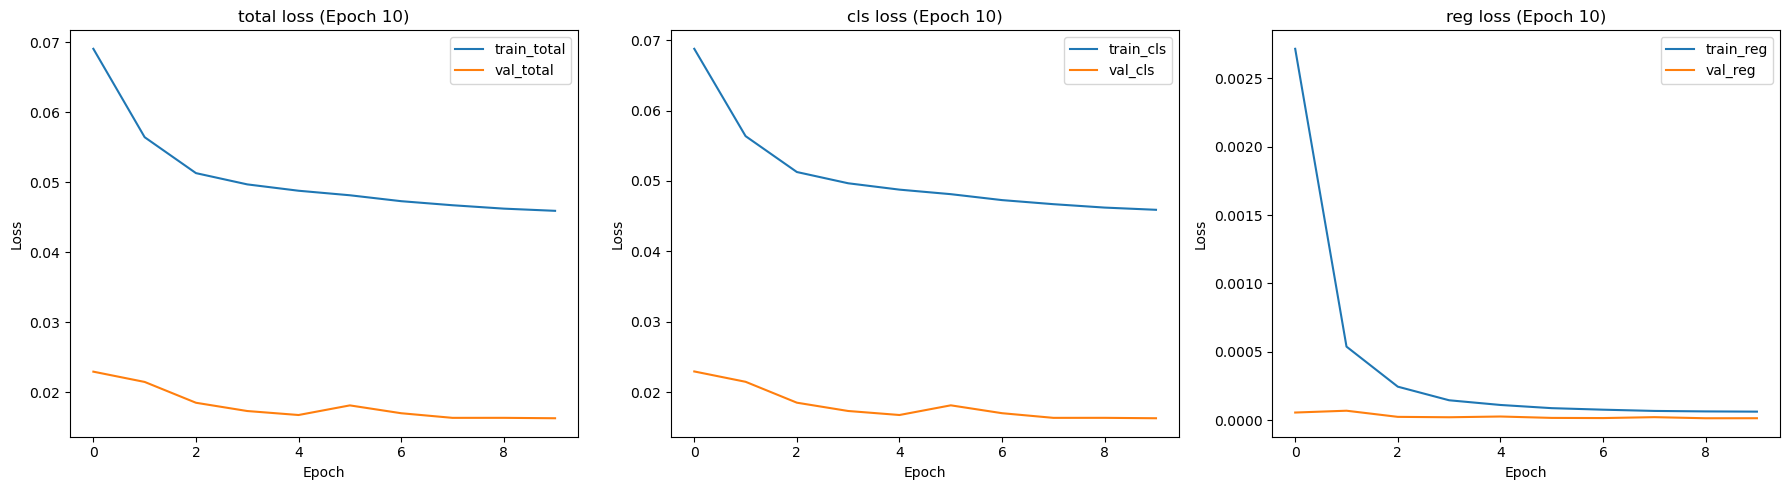

Best model found at epoch 10 with validation loss: 0.0163
Best model saved to: evaluation_results/best_transformer_model.pth


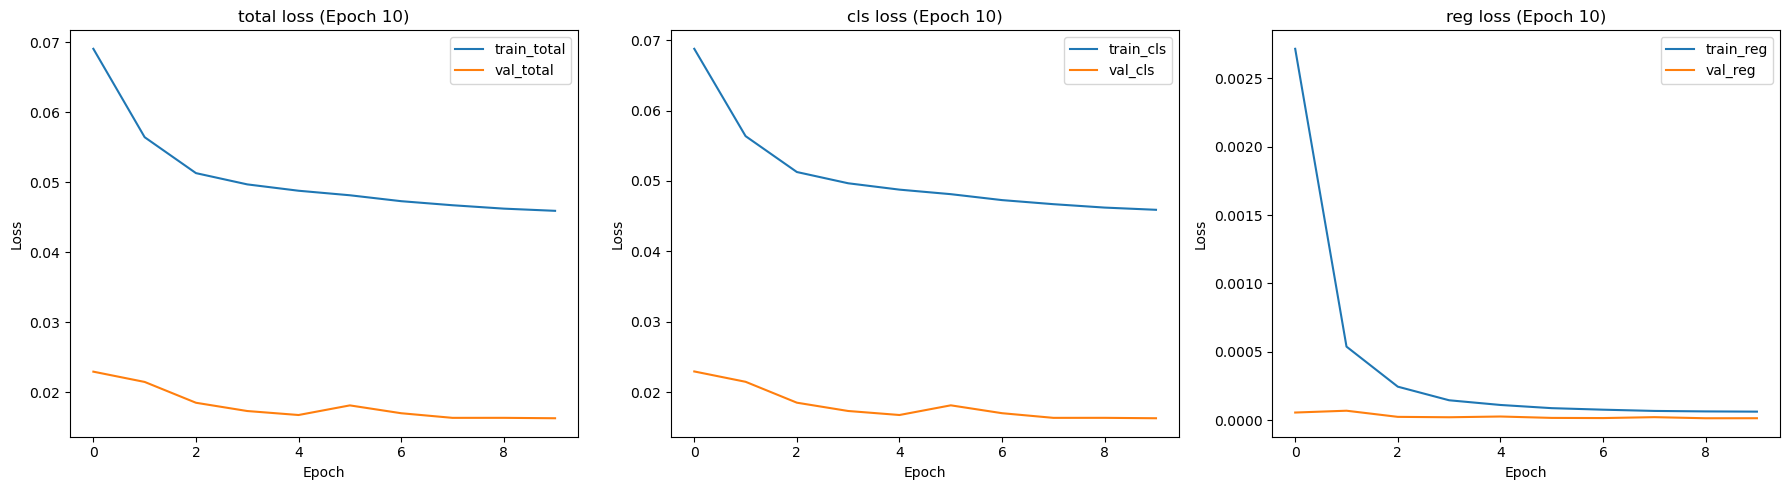

In [ ]:
# # Step 10: 学習ループ (tqdm + ライブプロット + 詳細評価 + ベストモデル保存)

# # --- このStep10のコードブロックを実行するための前提条件 ---
# # 以下のオブジェクト・変数は、これより前のStep (1-9) で定義・初期化されている必要があります:
# #   model, opt, sched, dl_tr, dl_val, df_valid, device, output_dir
# #   TransformerClassifierSoftLabel クラス定義
# #   ヘルパー関数: get_thresholded_predictions_final, log_future_price_change_stats_revised
# # 必要なライブラリ: torch, numpy as np, os, sklearn.metrics 各種, 
# #                 IPython.display (display, clear_output), matplotlib.pyplot as plt, tqdm.auto
# # -----------------------------------------------------------------

# print(f"INFO: Step 10 - Initializing variables and starting training loop.")

# # --- Step10で必要となるパラメータと状態変数の定義・初期化 ---
# EPOCHS = 30  # 例: 総エポック数 (実際の値に合わせてください)
# thresholds = [0.25, 0.5, 0.75] # 評価に使用する確率閾値のリスト
# target_names = ['Other', 'Min', 'Max'] # クラスラベル名
# FUTURE_STEPS = 6 # 将来の価格変動を何ステップ先まで見るか

# # 学習履歴保存用
# history = {'train_total':[], 'train_cls':[], 'train_reg':[],
#            'val_total':[],   'val_cls':[],   'val_reg':[]}

# # ベストモデル保存用
# min_val_loss = float('inf')
# # output_dir は Step7 で定義されている想定
# best_model_path = os.path.join(output_dir, "best_transformer_model.pth") 
# best_epoch = -1

# # ライブプロット用の図と軸を準備 (再実行時のために存在確認と初期化)
# # この fig_loss, ax_loss はこのStep10のブロック内で閉じることを推奨 (plt.close(fig_loss))
# # または、上位のスコープで管理し、ここではその存在を前提とする。
# # 今回は、このStep10内で完結するように初期化。
# if 'fig_loss' not in locals() or fig_loss is None or not plt.fignum_exists(fig_loss.number):
#     fig_loss, ax_loss = plt.subplots(1, 3, figsize=(18, 5))
#     print("INFO: Step 10 - Loss plot figure initialized.")
# # -------------------------------------------------------------

# print(f"INFO: Starting training and evaluation loop for {EPOCHS} epochs.")
# for ep in range(1, EPOCHS + 1):
#     # --- Train Phase ---
#     model.train()
#     train_run_metrics = {'total_loss': 0.0, 'cls_loss': 0.0, 'reg_loss': 0.0}
#     num_train_batches = 0
#     train_pbar = tqdm(dl_tr, desc=f"Epoch {ep}/{EPOCHS} [Train]", leave=False)
#     for Xb, yh_hard, ys_soft, y_reg_target, _ in train_pbar: # t_indices は訓練では未使用
#         Xb, yh_hard, ys_soft, y_reg_target = Xb.to(device), yh_hard.to(device), ys_soft.to(device), y_reg_target.to(device)
        
#         opt.zero_grad()
#         logits, reg_pred = model(Xb)
#         loss, lcls, lreg = model.compute_loss(logits, yh_hard, ys_soft, reg_pred, y_reg_target)
#         loss.backward()
#         opt.step()
        
#         train_run_metrics['total_loss'] += loss.item()
#         train_run_metrics['cls_loss'] += lcls # .item() は compute_loss 内で行われている前提
#         train_run_metrics['reg_loss'] += lreg # .item() は compute_loss 内で行われている前提
#         num_train_batches += 1
#         train_pbar.set_postfix({k_train: v_train / num_train_batches for k_train, v_train in train_run_metrics.items()})

#     if hasattr(sched, 'step'): # スケジューラが存在し、stepメソッドを持つ場合
#         sched.step()
    
#     history['train_total'].append(train_run_metrics['total_loss'] / num_train_batches if num_train_batches > 0 else 0)
#     history['train_cls'].append(train_run_metrics['cls_loss'] / num_train_batches if num_train_batches > 0 else 0)
#     history['train_reg'].append(train_run_metrics['reg_loss'] / num_train_batches if num_train_batches > 0 else 0)

#     # --- Validation Phase ---
#     if dl_val: # dl_val が None でないことを確認
#         model.eval()
#         val_run_metrics = {'total_loss': 0.0, 'cls_loss': 0.0, 'reg_loss': 0.0}
#         num_val_batches = 0
#         y_true_val_hard_all, probs_val_all, t_indices_val_all = [], [], []
        
#         val_pbar = tqdm(dl_val, desc=f"Epoch {ep}/{EPOCHS} [Val]", leave=False)
#         with torch.no_grad():
#             for Xb_val, yh_hard_val, ys_soft_val, y_reg_target_val, t_idx_val in val_pbar:
#                 Xb_val, yh_hard_val, ys_soft_val, y_reg_target_val = Xb_val.to(device), yh_hard_val.to(device), ys_soft_val.to(device), y_reg_target_val.to(device)
                
#                 logits_val, reg_pred_val = model(Xb_val)
#                 loss_val, lcls_val, lreg_val = model.compute_loss(logits_val, yh_hard_val, ys_soft_val, reg_pred_val, y_reg_target_val)
                
#                 val_run_metrics['total_loss'] += loss_val.item()
#                 val_run_metrics['cls_loss'] += lcls_val
#                 val_run_metrics['reg_loss'] += lreg_val
#                 num_val_batches += 1
#                 val_pbar.set_postfix({k_val: v_val / num_val_batches for k_val, v_val in val_run_metrics.items()})

#                 probs_val_all.append(torch.softmax(logits_val, dim=-1).cpu().numpy())
#                 y_true_val_hard_all.append(yh_hard_val.cpu().numpy())
#                 t_indices_val_all.append(t_idx_val.cpu().numpy())

#         current_epoch_val_total_loss = val_run_metrics['total_loss'] / num_val_batches if num_val_batches > 0 else float('inf')
#         history['val_total'].append(current_epoch_val_total_loss)
#         history['val_cls'].append(val_run_metrics['cls_loss'] / num_val_batches if num_val_batches > 0 else 0)
#         history['val_reg'].append(val_run_metrics['reg_loss'] / num_val_batches if num_val_batches > 0 else 0)

#         if current_epoch_val_total_loss < min_val_loss:
#             min_val_loss = current_epoch_val_total_loss
#             torch.save(model.state_dict(), best_model_path)
#             best_epoch = ep
#             # tqdmを使っている場合、printがバーを乱すことがあるため、ループ外での最終報告を推奨
#             # print(f"\nEpoch {ep}: New best model saved! Val Total Loss: {min_val_loss:.4f}") 
        
#         # --- Validation Metrics & Future Returns Analysis ---
#         if num_val_batches > 0:
#             y_true_np = np.concatenate(y_true_val_hard_all)
#             probs_np = np.concatenate(probs_val_all)
#             val_original_indices_np = np.concatenate(t_indices_val_all)

#             # ファイル名はエポック番号を3桁ゼロ埋めにするなど工夫するとソートしやすい
#             metrics_filepath = os.path.join(output_dir, f"validation_metrics_ep{ep:03d}.txt")
#             returns_filepath = os.path.join(output_dir, f"validation_future_returns_ep{ep:03d}.txt")

#             with open(metrics_filepath, "w") as f_metrics, open(returns_filepath, "w") as f_returns:
#                 f_metrics.write(f"Epoch {ep} - Validation Set Metrics\n")
#                 f_returns.write(f"Epoch {ep} - Validation Set Future Returns Analysis\n")
                
#                 f_metrics.write("="*50 + "\nOverall Class-Specific AUCs (Threshold-Independent):\n")
#                 for class_idx, class_name in enumerate(target_names):
#                     if class_idx == 0: continue # Skip 'Other' class for this specific AUC reporting
#                     if np.any(y_true_np == class_idx) and np.any(y_true_np != class_idx):
#                         try:
#                             roc_auc = roc_auc_score((y_true_np == class_idx).astype(int), probs_np[:, class_idx])
#                             precision, recall, _ = precision_recall_curve((y_true_np == class_idx).astype(int), probs_np[:, class_idx])
#                             pr_auc = auc(recall, precision)
#                             f_metrics.write(f"  {class_name} - ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}\n")
#                         except ValueError as e_auc: # ハンドリングを追加
#                              f_metrics.write(f"  {class_name} - ROC-AUC: Error ({e_auc}), PR-AUC: Error\n")
#                     else:
#                         f_metrics.write(f"  {class_name} - ROC-AUC: N/A, PR-AUC: N/A (Insufficient class diversity or no samples for this class)\n")
#                 f_metrics.write("="*50 + "\n\n")

#                 for th in thresholds:
#                     f_metrics.write(f"--- Metrics for Threshold: {th:.2f} ---\n")
#                     f_returns.write(f"--- Returns Analysis for Threshold: {th:.2f} ---\n")

#                     # get_thresholded_predictions_final は事前に定義されている前提
#                     y_pred_at_threshold = get_thresholded_predictions_final(probs_np, th)
                    
#                     cm = confusion_matrix(y_true_np, y_pred_at_threshold, labels=[0,1,2])
#                     f_metrics.write("Confusion Matrix:\n" + np.array2string(cm) + "\n\n")
#                     try:
#                         cr = classification_report(y_true_np, y_pred_at_threshold, target_names=target_names, labels=[0,1,2], zero_division=0, digits=4)
#                         f_metrics.write("Classification Report:\n" + cr + "\n\n")
#                     except Exception as e_cr: 
#                         f_metrics.write(f"Could not generate Classification Report for threshold {th:.2f}: {e_cr}\n\n")

#                     f1_min = f1_score((y_true_np == 1).astype(int), (probs_np[:, 1] > th).astype(int), zero_division=0)
#                     f1_max = f1_score((y_true_np == 2).astype(int), (probs_np[:, 2] > th).astype(int), zero_division=0)
#                     f_metrics.write(f"Binary F1-score (Min vs Rest) @{th:.2f}: {f1_min:.4f}\n")
#                     f_metrics.write(f"Binary F1-score (Max vs Rest) @{th:.2f}: {f1_max:.4f}\n")
#                     f_metrics.write("-" * 40 + "\n\n")
                    
#                     # log_future_price_change_stats_revised は事前に定義されている前提
#                     # df_valid は上位スコープから参照
#                     log_future_price_change_stats_revised(f_returns, y_pred_at_threshold, val_original_indices_np, df_valid,
#                                                           1, target_names[1], FUTURE_STEPS, th)
#                     log_future_price_change_stats_revised(f_returns, y_pred_at_threshold, val_original_indices_np, df_valid,
#                                                           2, target_names[2], FUTURE_STEPS, th)
            
#             # tqdmを使っている場合、printがバーを乱すことがあるため、ループ外での最終報告を推奨
#             # if ep < EPOCHS: print() # ループの最後以外で改行を入れるなど工夫
#     else: # dl_val がない場合
#         history['val_total'].append(float('inf')) # val_lossは無限大として扱う
#         history['val_cls'].append(0)
#         history['val_reg'].append(0)

#     # --- Plot Losses ---
#     clear_output(wait=True) # Jupyter Notebook/Lab環境でプロットを更新表示
#     for i, key_suffix in enumerate(['total', 'cls', 'reg']):
#         ax = ax_loss[i] # ax_loss[i] を ax に代入
#         ax.clear()
#         ax.plot(history[f'train_{key_suffix}'], label=f'train_{key_suffix}')
#         # valのロスが記録されているか、かつinfでない場合のみプロット
#         if dl_val and len(history[f'val_{key_suffix}']) > 0 and not np.all(np.isinf(history[f'val_{key_suffix}'])):
#              ax.plot(history[f'val_{key_suffix}'], label=f'val_{key_suffix}')
#         ax.set_title(f"{key_suffix.capitalize()} Loss (Epoch {ep})")
#         ax.set_xlabel("Epoch")
#         ax.set_ylabel("Average Loss")
#         ax.legend()
#     fig_loss.tight_layout()
#     display(fig_loss) # Jupyter Notebook/Lab環境で図を表示

# # --- End of Training Loop ---
# print("\nINFO: Step 10 - Training Loop Finished ---")
# if best_epoch != -1:
#     print(f"Best model found at epoch {best_epoch} with validation total loss: {min_val_loss:.4f}")
#     print(f"Best model weights saved to: {best_model_path}")
# else:
#     print("No best model was saved (either validation loss did not improve or no validation data was provided).")

# # 学習ループ終了後にプロットウィンドウを閉じる場合は以下を有効化
# # plt.close(fig_loss)

## step11

In [70]:
# Step 11: テスト評価 (詳細評価) - Step10からの独立性を確保したバージョン (修正版)

# --- 必要なライブラリ (スクリプトの先頭やヘルパー関数定義部でインポート済みと仮定) ---
# import torch
# import numpy as np
# import os
# from tqdm.auto import tqdm # perform_detailed_evaluation内で使用
# (perform_detailed_evaluation およびそのヘルパー関数内で必要な sklearn.metrics なども同様)

# --- このStep11のコードブロックを実行するための前提条件 ---
# 1. モデルクラス定義 (事前にグローバルスコープで定義されていること):
#     TransformerClassifierSoftLabel
# 2. ヘルパー関数群 (事前にグローバルスコープで定義されていること):
#     get_thresholded_predictions_final(probs_np, threshold_val)
#     calculate_signal_statistics(y_predictions_at_threshold, ...) # ★修正済み関数
#     format_future_stats_table_row(pred_type_str, ...)
#     perform_detailed_evaluation(model_instance, ...) # ★修正済みヘルパーを利用する関数
# 3. 必須オブジェクト・変数 (以前のステップで準備され、グローバルスコープで利用可能であること):
#    - dl_test: torch.utils.data.DataLoader - テスト用データローダー (Step8で作成)
#    - df_valid: pd.DataFrame - テストデータのインデックスがマッピングできる元のDataFrame (Step5でロード・処理)
#                              'soft_label' カラムを含むことが期待される。
#    - device: str - 計算デバイス (Step3で定義)
#    - output_dir: str - 結果ファイル等を保存するディレクトリパス (Step7で定義)
#    - SEQ_LEN: int - モデル入力のシーケンス長 (Step7で定義)
# ------------------------------------------------------------------------------------

print("\nINFO: Step 11 - Starting Test Set Evaluation.")
print("INFO: This step defines its own evaluation parameters for independence.")
print("      It relies on a saved model specified by 'BEST_MODEL_PATH_S11'.")

# --- Step 11 固有の評価パラメータと設定をここで定義 ---
TARGET_NAMES_S11 = ['Other', 'Min', 'Max']    # クラスラベル名
THRESHOLDS_S11 = [0.25, 0.5, 0.75]        # 評価に使用する確率閾値のリスト
FUTURE_STEPS_S11 = 6                      # 将来の価格変動を何ステップ先まで見るか

BEST_MODEL_PATH_S11 = os.path.join(output_dir, "best_transformer_model.pth")
EPOCH_INFO_FOR_FILE_S11 = "best_model_file"
# ----------------------------------------------------

# --- 必須グローバル変数の存在チェック (主要なもの) ---
essential_globals_s11 = {
    'dl_test': "Test DataLoader", 'df_valid': "Source DataFrame for test context",
    'device': "Device string", 'output_dir': "Output directory path",
    'SEQ_LEN': "Sequence length parameter",
    'TransformerClassifierSoftLabel': "Model class definition",
    'perform_detailed_evaluation': "Main evaluation helper function",
    'get_thresholded_predictions_final': "Prediction helper function",
    'calculate_signal_statistics': "Statistics helper function", # ★関数名を修正
    'format_future_stats_table_row': "Table formatting helper function"
}
all_prerequisites_available_s11 = True
for var, name in essential_globals_s11.items():
    if var not in globals() and var not in locals(): # globals()だけでなくlocals()も確認
        print(f"ERROR: Prerequisite '{name}' (variable/function: {var}) for Step 11 is not defined.")
        all_prerequisites_available_s11 = False

if not all_prerequisites_available_s11:
    raise NameError("Missing one or more crucial prerequisites for Step 11. Evaluation cannot proceed.")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"INFO: Created output directory for Step 11 results: {output_dir}")
# ---------------------------------------------

model_for_testing_s11 = TransformerClassifierSoftLabel().to(device)
evaluation_performed_s11 = False

if dl_test is not None:
    if os.path.exists(BEST_MODEL_PATH_S11):
        print(f"INFO: Found model file at '{BEST_MODEL_PATH_S11}'. Attempting to load weights...")
        try:
            model_for_testing_s11.load_state_dict(torch.load(BEST_MODEL_PATH_S11, map_location=device))
            print(f"INFO: Successfully loaded model weights from '{BEST_MODEL_PATH_S11}'.")

            # perform_detailed_evaluation 関数を呼び出し
            # original_df_for_lookup (ここでは df_valid) が 'soft_label' カラムを持つことを期待
            perform_detailed_evaluation(
                model_instance=model_for_testing_s11,
                dataloader_to_eval=dl_test,
                original_df_for_lookup=df_valid, # ★テストデータがdf_valid由来であることを確認
                device_to_use=device,
                output_path=output_dir,
                file_prefix_str="test_independent_eval",
                class_target_names=TARGET_NAMES_S11,
                prob_thresholds=THRESHOLDS_S11,
                num_future_steps=FUTURE_STEPS_S11,
                epoch_info_str=EPOCH_INFO_FOR_FILE_S11
            )
            evaluation_performed_s11 = True
        except Exception as e:
            print(f"ERROR: Failed to load or evaluate model from '{BEST_MODEL_PATH_S11}'. Error: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"ERROR: Specified model path '{BEST_MODEL_PATH_S11}' does not exist.")
        print("INFO: Cannot perform evaluation. Please ensure a trained model is saved at this path,")
        print("      or update 'BEST_MODEL_PATH_S11' (defined at the start of Step 11) to the correct file path.")

    if not evaluation_performed_s11:
        print("INFO: Step 11 - No evaluation was successfully performed with a trained model.")
else:
    print("INFO: Test data loader (dl_test) is None. Skipping test evaluation.")

print("INFO: Step 11 - Test Evaluation Phase Finished.")


INFO: Step 11 - Starting Test Set Evaluation.
INFO: This step defines its own evaluation parameters for independence.
      It relies on a saved model specified by 'BEST_MODEL_PATH_S11'.


/home/nagumo/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


INFO: Found model file at 'evaluation_results/best_transformer_model.pth'. Attempting to load weights...
INFO: Successfully loaded model weights from 'evaluation_results/best_transformer_model.pth'.

--- Starting Detailed Evaluation for: test_independent_eval (Source Epoch for Model: best_model_file) ---


Evaluating test_independent_eval:   0%|          | 0/781 [00:00<?, ?it/s]

INFO: Detailed metrics for 'test_independent_eval' saved to: evaluation_results/test_independent_eval_metrics_epbest_model_file.txt
INFO: Future returns analysis (text) for 'test_independent_eval' saved to: evaluation_results/test_independent_eval_future_returns_epbest_model_file.txt
INFO: Future returns table (CSV) for 'test_independent_eval' saved to: evaluation_results/test_independent_eval_future_returns_epbest_model_file.csv
--- Finished Detailed Evaluation for: test_independent_eval ---
INFO: Step 11 - Test Evaluation Phase Finished.


In [66]:
test_future_metrics = pd.read_csv(os.path.join(output_dir, "test_independent_eval_future_returns_epbest_model_file.csv"))
test_future_metrics

,Threshold,Prediction Type,Fut_Low_Mean,Fut_Low_Median,Fut_Low_Q1,Fut_Low_Q3,Fut_High_Mean,Fut_High_Median,Fut_High_Q1,Fut_High_Q3,...,SLMinC_Median,SLMinC_Q1,SLMinC_Q3,SLMinC_Std,SLMaxC_Mean,SLMaxC_Median,SLMaxC_Q1,SLMaxC_Q3,SLMaxC_Std,N_Pred
0,0.25,Min Predictions,-0.4825,-0.2768,-0.5946,-0.1247,0.4067,0.3070,0.1780,0.5157,...,0.3013,0.2144,0.4408,0.1934,0.1550,0.1438,0.1175,0.1718,0.0840,2383
1,0.25,Max Predictions,-0.4671,-0.3321,-0.5895,-0.1791,0.5174,0.2990,0.1403,0.6111,...,0.1414,0.1147,0.1736,0.0928,0.3454,0.2968,0.2075,0.4274,0.1938,2510
2,0.50,Min Predictions,-0.7657,-0.4732,-0.9274,-0.1910,0.6580,0.5181,0.2941,0.8545,...,0.6524,0.4748,0.7987,0.2392,0.1424,0.1093,0.0600,0.1877,0.1307,279
3,0.50,Max Predictions,-0.8817,-0.6826,-1.1645,-0.3382,0.7935,0.4672,0.2005,0.9507,...,0.0886,0.0417,0.1637,0.1392,0.6497,0.6889,0.5106,0.8436,0.2384,254
4,0.75,Min Predictions,-1.4304,-1.0771,-2.1123,-0.3041,1.3861,1.0286,0.6455,1.5128,...,0.9601,0.7005,0.9934,0.2706,0.1111,0.0239,0.0027,0.1583,0.1661,30
5,0.75,Max Predictions,-1.2291,-0.8907,-1.6920,-0.3776,1.2935,0.9725,0.4217,1.9012,...,0.0312,0.0070,0.0701,0.1638,0.8500,0.9188,0.8331,0.9816,0.1985,34


step12

INFO: Step 12 - Initializing for plotting signals and P&L simulation (standalone focus).
INFO: Step 12 - Processing period: 2023-09-01 to 2023-09-30, Threshold: 0.6
INFO: Loading model for plotting from: evaluation_results/best_transformer_model.pth
INFO: Generating sequences from the selected df_valid slice (length: 8927)...
INFO: Predicting on 8640 generated sequences...
INFO: Generated 8640 prediction labels using threshold 0.6.
INFO: Found 16 Min/Max signals to plot/simulate within the specified range.
INFO: Position of 1 unit(s) entered at 26943.00 liquidated at EOP (2023-09-30 23:55) price 26961.00.

--- P&L Simulation Results (Step 12) ---
Simulation Period: 2023-09-01 to 2023-09-30
Signal Threshold: 0.6
Trade Unit: 1
------------------------------ Trade Log ------------------------------
2023-09-01 17:25: BUY 1 unit(s) at 25371.63
2023-09-07 21:05: SELL 1 unit(s) at 26249.90 | P/L: 878.27
2023-09-08 10:05: BUY 1 unit(s) at 25740.00
2023-09-12 03:15: SELL 1 unit(s) at 25588.74 |

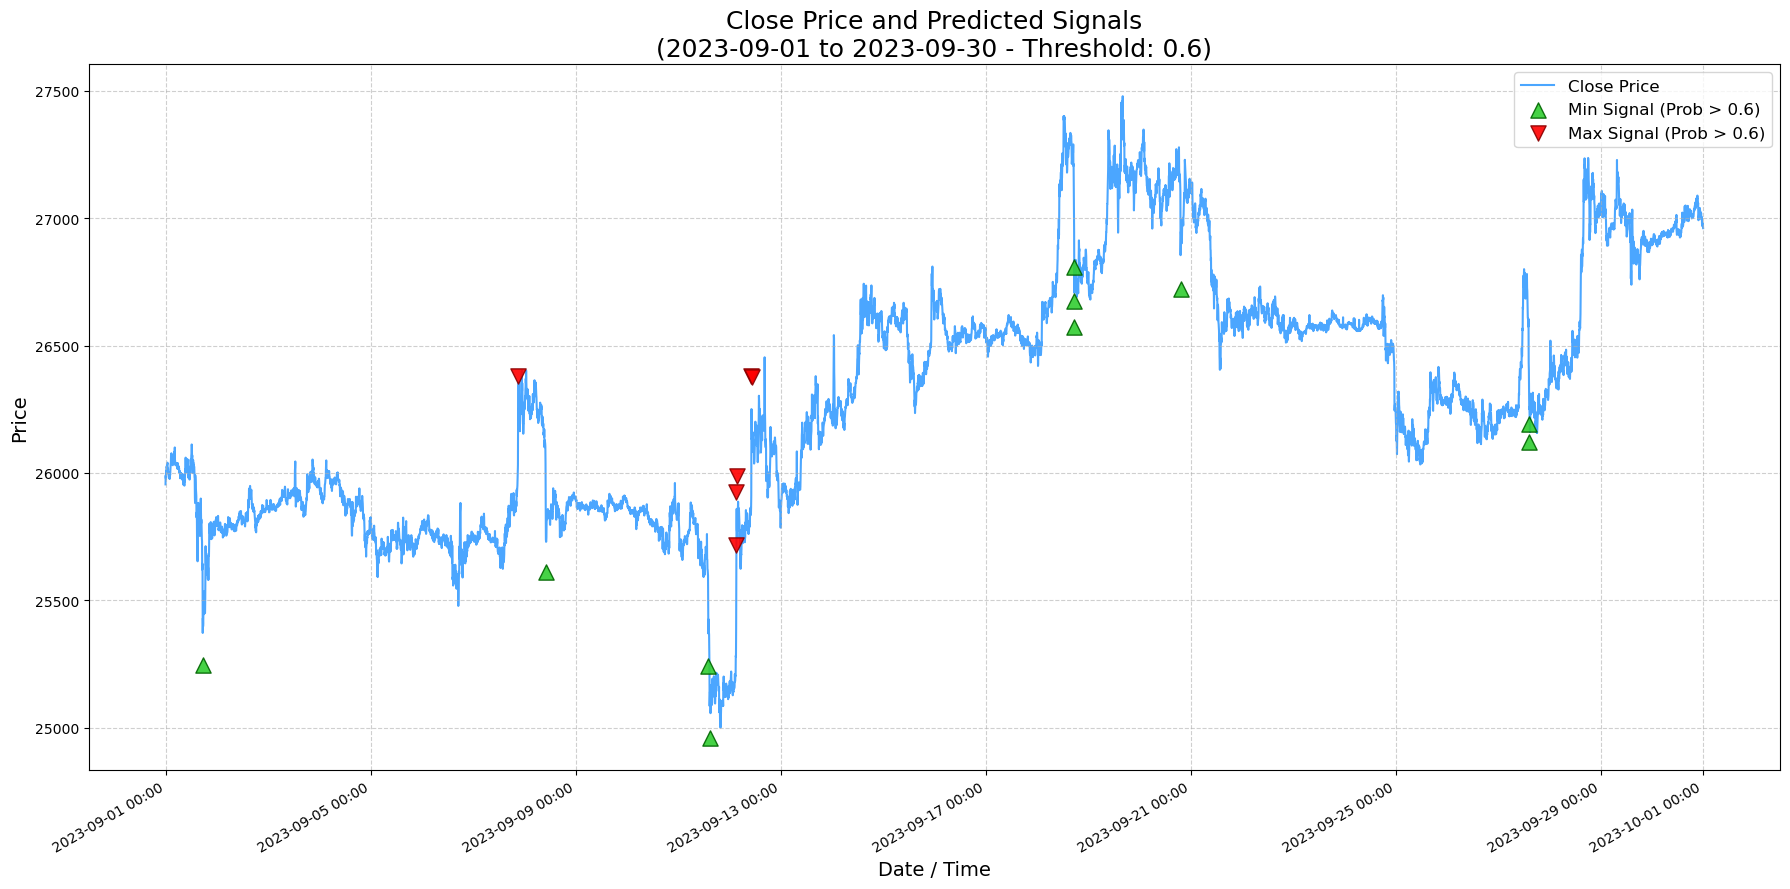

INFO: Step 12 - Plotting and P&L simulation process finished.


In [24]:
# Step 12: 特定期間のClose時系列と予測シグナルのプロット + 詳細な収益シミュレーション (独立実行版)

# --- 必要なライブラリ (スクリプトの先頭で一度インポートすることを推奨) ---
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # 日付フォーマットのためインポート
import os
# from tqdm.auto import tqdm # make_sequences_for_plot で tqdm を使う場合に必要

# --- このStep12のコードブロックを実行するための前提条件 ---
# 以下のオブジェクト・変数は、これより前のStep (主にStep1～9) で定義・初期化されている必要があります:
#   - df_valid: pd.DataFrame 
#       検証データセットの元となったDataFrame。日時インデックスを持ち、'close', 'high', 'low', 'volume' カラムを含むこと。
#   - TransformerClassifierSoftLabel: class 
#       モデルのクラス定義 (Step9で定義)。__init__の引数は学習時と同じものを想定。
#   - device: str 
#       計算デバイス ('cuda' または 'cpu') (Step3で定義)。
#   - SEQ_LEN: int 
#       モデルの入力シーケンス長 (Step7で定義)。
#   - output_dir: str 
#       結果ファイル等を保存するディレクトリパス (Step7で定義)。
# ------------------------------------------------------------------------------------

print("INFO: Step 12 - Initializing for plotting signals and P&L simulation (standalone focus).")

# === Step 12 固有のパラメータ定義 ===
# これらの値を変更することで、プロット対象の閾値や期間を簡単に調整できます。
PLOT_THRESHOLD_S12 = 0.6        # シグナル判定の確率閾値
PLOT_START_DATE_S12 = "2023-09-01"  # プロットおよびシミュレーション開始日 (YYYY-MM-DD)
PLOT_END_DATE_S12 = "2023-09-30"    # プロットおよびシミュレーション終了日 (YYYY-MM-DD)
SIM_TRADE_UNIT_S12 = 1            # 取引単位 (例: 1 BTC)

# ベストモデルのパスは output_dir と固定ファイル名で構築
# このパスに、事前に学習・保存されたモデルが存在することを期待します。
BEST_MODEL_PATH_S12 = os.path.join(output_dir, "best_transformer_model.pth") 
# =====================================

# --- Step 12 で使用するヘルパー関数の定義 ---
# (これらの関数は、以前の回答で提示したものをここに含めることで、Step12の独立性を高めます)

def make_sequences_for_plot(df_segment, seq_len, description="Making sequences for plot"):
    """
    DataFrameセグメントからプロット/予測用のシーケンス特徴量と元インデックスを生成します。
    ラベル関連の処理は含みません。
    """
    X_plot, t_indices_plot_relative = [], []
    # プログレスバーが必要な場合は tqdm(range(...)) を使用
    # for t in tqdm(range(seq_len - 1, len(df_segment)), desc=description, unit="sequence", leave=False):
    for t in range(seq_len - 1, len(df_segment)): # 現在はtqdmなし
        win = df_segment.iloc[t - seq_len + 1 : t + 1]
        
        # ウィンドウ内のデータが不足している場合はスキップ (例: df_segmentの先頭部分)
        if len(win) < seq_len:
            continue
            
        c0 = win['close'].iloc[-1]
        v0 = win['volume'].iloc[-1]

        # .values を使ってNumPy配列として処理
        norm_close = win['close'].values / c0
        norm_high = win['high'].values / c0
        norm_low = win['low'].values / c0
        
        if v0 != 0:
            normalized_volume = win['volume'].values / v0
        else:
            normalized_volume = np.zeros_like(win['volume'].values, dtype=float)
        
        # 特徴量の次元数を確認 (通常は4)
        if normalized_volume.ndim == 0: # スカラーになってしまった場合 (ウィンドウ長が1の場合など)
             normalized_volume = np.array([normalized_volume] * seq_len) # 形状を合わせる (要検討)

        feats = np.stack([norm_close, norm_high, norm_low, normalized_volume], axis=1)
        X_plot.append(feats)
        # t_indices_plot_relative には、現在の df_segment におけるウィンドウ最終点のilocを格納
        t_indices_plot_relative.append(t) 
        
    if not X_plot: # シーケンスが一つも作れなかった場合
        # モデルの入力形状 (N, SEQ_LEN, num_features) に合わせる
        return np.array([]).reshape(0, seq_len, 4 if seq_len > 0 else 0), np.array([], dtype=int)
    return np.array(X_plot, dtype=np.float32), np.array(t_indices_plot_relative, dtype=int)

def get_thresholded_predictions_final(probs_np, threshold_val):
    """ 確率配列と閾値から3クラス予測(0,1,2)を生成する """
    y_pred_thresh = np.zeros(len(probs_np), dtype=int) 
    if probs_np.ndim < 2 or probs_np.shape[1] < 3: # 確率が期待する形状でない場合
        print("WARNING: probs_np shape is not as expected in get_thresholded_predictions_final.")
        return y_pred_thresh # 空または不適切な予測を返す

    prob_min_scores = probs_np[:, 1] 
    prob_max_scores = probs_np[:, 2] 

    for i in range(len(probs_np)):
        is_min_candidate = prob_min_scores[i] >= threshold_val
        is_max_candidate = prob_max_scores[i] >= threshold_val

        if is_min_candidate and is_max_candidate:
            if prob_min_scores[i] >= prob_max_scores[i]:
                y_pred_thresh[i] = 1 
            else:
                y_pred_thresh[i] = 2 
        elif is_min_candidate:
            y_pred_thresh[i] = 1 
        elif is_max_candidate:
            y_pred_thresh[i] = 2 
    return y_pred_thresh
# ----------------------------------------------------

# --- Step 12 メイン処理開始 ---
try:
    # --- 0. 必須変数の存在確認 (主要なグローバル変数) ---
    required_globals_s12 = {
        'df_valid': "Validation DataFrame", 'device': "Device string", 
        'output_dir': "Output directory path", 'SEQ_LEN': "Sequence length parameter",
        'TransformerClassifierSoftLabel': "Model class definition"
    }
    for var, name in required_globals_s12.items():
        if var not in globals() and var not in locals():
            raise NameError(f"Prerequisite '{name}' (variable/class: {var}) for Step 12 is not defined.")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"INFO: Created output directory for Step 12: {output_dir}")
    # ---------------------------------------------

    plot_start_dt_s12 = pd.to_datetime(PLOT_START_DATE_S12)
    plot_end_dt_s12 = pd.to_datetime(PLOT_END_DATE_S12).replace(hour=23, minute=59, second=59, microsecond=999999)
    if plot_start_dt_s12 > plot_end_dt_s12:
        raise ValueError("Plot start date cannot be after plot end date.")

    print(f"INFO: Step 12 - Processing period: {plot_start_dt_s12.strftime('%Y-%m-%d')} to {plot_end_dt_s12.strftime('%Y-%m-%d')}, Threshold: {PLOT_THRESHOLD_S12}")

    # --- 1. 必要なDataFrameスライスの準備 ---
    # df_valid のインデックスが DatetimeIndex であることを確認
    if not isinstance(df_valid.index, pd.DatetimeIndex):
        raise TypeError("df_valid.index must be a DatetimeIndex for date-based slicing.")
        
    # プロット期間よりSEQ_LEN-1だけ前のデータから取得開始
    # searchsorted はソート済み配列に対して有効
    if not df_valid.index.is_monotonic_increasing:
        print("WARNING: df_valid.index is not monotonically increasing. Sorting now. This might affect iloc mapping if not careful.")
        df_valid = df_valid.sort_index()

    first_event_iloc = df_valid.index.searchsorted(plot_start_dt_s12)
    slice_start_iloc = max(0, first_event_iloc - (SEQ_LEN - 1) if SEQ_LEN > 0 else first_event_iloc)
    
    last_event_iloc = df_valid.index.searchsorted(plot_end_dt_s12, side='right') # 指定時刻以降の最初の要素
    df_segment_for_plot_s12 = df_valid.iloc[slice_start_iloc:last_event_iloc]

    if df_segment_for_plot_s12.empty or len(df_segment_for_plot_s12) < SEQ_LEN:
        print(f"WARNING: Not enough data in df_valid (from iloc {slice_start_iloc} to {last_event_iloc}) "
              f"for the period (and SEQ_LEN padding) to generate any sequences. "
              f"Required at least {SEQ_LEN} rows, got {len(df_segment_for_plot_s12)}.")
        raise SystemExit("Plotting and P&L simulation aborted due to insufficient data for sequences.")

    # --- 2. モデルのロード ---
    model_plot_s12 = TransformerClassifierSoftLabel().to(device) # 学習時と同じパラメータで初期化
    if os.path.exists(BEST_MODEL_PATH_S12):
        print(f"INFO: Loading model for plotting from: {BEST_MODEL_PATH_S12}")
        model_plot_s12.load_state_dict(torch.load(BEST_MODEL_PATH_S12, map_location=device))
    else:
        print(f"WARNING: Model file not found at {BEST_MODEL_PATH_S12}. Plotting will use an uninitialized model (random signals).")
    model_plot_s12.eval()

    # --- 3. スライスされたデータからシーケンス生成と予測 ---
    print(f"INFO: Generating sequences from the selected df_valid slice (length: {len(df_segment_for_plot_s12)})...")
    X_plot_segment, t_indices_segment_relative = make_sequences_for_plot(df_segment_for_plot_s12, SEQ_LEN)
    
    # t_indices_segment_relative は df_segment_for_plot_s12 内のインデックス。
    # 元の df_valid 全体での iloc インデックスに変換する。
    t_indices_absolute_in_df_valid = t_indices_segment_relative + slice_start_iloc

    probs_for_plot_np_s12 = None
    if X_plot_segment.size > 0: # Check if any sequences were actually created
        print(f"INFO: Predicting on {len(X_plot_segment)} generated sequences...")
        with torch.no_grad():
            X_plot_tensor = torch.from_numpy(X_plot_segment).float().to(device)
            logits_plot, _ = model_plot_s12(X_plot_tensor)
            probs_for_plot_np_s12 = torch.softmax(logits_plot, dim=-1).cpu().numpy()
    else:
        print("WARNING: No sequences were generated from the data segment for the plot range.")

    if probs_for_plot_np_s12 is not None and probs_for_plot_np_s12.size > 0:
        pred_labels_for_plot_s12 = get_thresholded_predictions_final(probs_for_plot_np_s12, PLOT_THRESHOLD_S12)
        print(f"INFO: Generated {len(pred_labels_for_plot_s12)} prediction labels using threshold {PLOT_THRESHOLD_S12}.")

        # --- 4. プロット対象のClose価格とシグナルイベントのリスト作成 ---
        close_prices_to_plot_s12 = df_valid.loc[plot_start_dt_s12:plot_end_dt_s12]['close']

        plot_min_signal_times, plot_min_signal_markers_y = [], []
        plot_max_signal_times, plot_max_signal_markers_y = [], []
        simulation_events = []
        num_signals_in_range_s12 = 0

        for i, absolute_df_valid_iloc in enumerate(t_indices_absolute_in_df_valid):
            # absolute_df_valid_iloc が df_valid の範囲内であることを再確認
            if not (0 <= absolute_df_valid_iloc < len(df_valid)): continue

            timestamp = df_valid.index[absolute_df_valid_iloc] # ウィンドウ最終点のタイムスタンプ
            
            if plot_start_dt_s12 <= timestamp <= plot_end_dt_s12:
                trade_price = df_valid['close'].iloc[absolute_df_valid_iloc]
                if pd.isna(trade_price): continue

                predicted_label = pred_labels_for_plot_s12[i]
                # プロット用マーカーオフセット（価格の0.5%）
                marker_offset = trade_price * 0.005 
                
                if predicted_label == 1: # Min signal (BUY)
                    plot_min_signal_times.append(timestamp)
                    plot_min_signal_markers_y.append(trade_price - marker_offset) 
                    simulation_events.append({'time': timestamp, 'type': 'BUY', 'price': trade_price})
                    num_signals_in_range_s12 +=1
                elif predicted_label == 2: # Max signal (SELL)
                    plot_max_signal_times.append(timestamp)
                    plot_max_signal_markers_y.append(trade_price + marker_offset) 
                    simulation_events.append({'time': timestamp, 'type': 'SELL', 'price': trade_price})
                    num_signals_in_range_s12 +=1
        
        print(f"INFO: Found {num_signals_in_range_s12} Min/Max signals to plot/simulate within the specified range.")
        simulation_events.sort(key=lambda x: x['time'])

        # --- 5. 収益シミュレーション実行 ---
        total_profit_s12 = 0.0
        num_trades_s12 = 0
        in_position_s12 = False
        entry_price_s12 = 0.0
        position_size_s12 = 0 
        trade_log_s12 = []

        for event in simulation_events:
            event_time, event_type, event_price = event['time'], event['type'], event['price']
            if event_type == 'BUY' and not in_position_s12:
                in_position_s12 = True
                entry_price_s12 = event_price
                position_size_s12 = SIM_TRADE_UNIT_S12
                trade_log_s12.append(f"{event_time.strftime('%Y-%m-%d %H:%M')}: BUY {position_size_s12} unit(s) at {entry_price_s12:.2f}")
            elif event_type == 'SELL' and in_position_s12:
                exit_price_s12 = event_price
                profit_this_trade = (exit_price_s12 - entry_price_s12) * position_size_s12
                total_profit_s12 += profit_this_trade
                num_trades_s12 += 1
                trade_log_s12.append(f"{event_time.strftime('%Y-%m-%d %H:%M')}: SELL {position_size_s12} unit(s) at {exit_price_s12:.2f} | P/L: {profit_this_trade:.2f}")
                in_position_s12 = False; entry_price_s12 = 0.0; position_size_s12 = 0
        
        if in_position_s12: # 期間終了時のポジション処理
            eop_timestamp = plot_end_dt_s12 # 期間最終日時
            # 期間最終日時までの最新の終値を取得 (df_valid全体から)
            last_closes_in_period_or_before = df_valid.loc[df_valid.index <= eop_timestamp]['close']
            if not last_closes_in_period_or_before.empty:
                last_available_close_price = last_closes_in_period_or_before.iloc[-1]
                eop_settle_timestamp = last_closes_in_period_or_before.index[-1] # 実際の最終価格の時刻

                if not pd.isna(last_available_close_price):
                    profit_this_trade = (last_available_close_price - entry_price_s12) * position_size_s12
                    total_profit_s12 += profit_this_trade
                    num_trades_s12 += 1 
                    trade_log_s12.append(f"{eop_settle_timestamp.strftime('%Y-%m-%d %H:%M')}: EOP LIQUIDATE {position_size_s12} unit(s) at {last_available_close_price:.2f} | P/L: {profit_this_trade:.2f}")
                    print(f"INFO: Position of {position_size_s12} unit(s) entered at {entry_price_s12:.2f} liquidated at EOP ({eop_settle_timestamp.strftime('%Y-%m-%d %H:%M')}) price {last_available_close_price:.2f}.")
                else:
                    trade_log_s12.append(f"EOP: Holding {position_size_s12} unit(s) entered at {entry_price_s12:.2f}, but last available EOP price is NaN.")
            else:
                trade_log_s12.append(f"EOP: Holding {position_size_s12} unit(s) entered at {entry_price_s12:.2f}, but no closing price available for liquidation on/before {eop_timestamp.strftime('%Y-%m-%d')}.")
                print(f"WARNING: Position held at EOP, but no valid closing price found for liquidation on/before {eop_timestamp.strftime('%Y-%m-%d')}.")

        # --- 6. シミュレーション結果表示 ---
        print("\n--- P&L Simulation Results (Step 12) ---")
        print(f"Simulation Period: {plot_start_dt_s12.strftime('%Y-%m-%d')} to {plot_end_dt_s12.strftime('%Y-%m-%d')}")
        print(f"Signal Threshold: {PLOT_THRESHOLD_S12}")
        print(f"Trade Unit: {SIM_TRADE_UNIT_S12}")
        print("-" * 30 + " Trade Log " + "-" * 30)
        if trade_log_s12:
            for log_entry in trade_log_s12: print(log_entry)
        else: print("No trades executed during the period.")
        print("-" * (60 + len(" Trade Log ")))
        print(f"Total Number of Trades: {num_trades_s12}")
        print(f"Total Profit/Loss: {total_profit_s12:.2f}")
        if num_trades_s12 > 0: print(f"Average Profit/Loss per Trade: {(total_profit_s12 / num_trades_s12):.2f}")
        print("--- End of P&L Simulation Results ---")

        # --- 7. プロット実行 ---
        plt.figure(figsize=(18, 9))
        if not close_prices_to_plot_s12.empty:
            plt.plot(close_prices_to_plot_s12.index, close_prices_to_plot_s12.values, 
                     label='Close Price', color='dodgerblue', alpha=0.8, linewidth=1.5, zorder=1)
        
        if plot_min_signal_times:
            plt.scatter(plot_min_signal_times, plot_min_signal_markers_y, 
                        label=f'Min Signal (Prob > {PLOT_THRESHOLD_S12})', 
                        marker='^', color='limegreen', s=120, alpha=0.9, edgecolors='darkgreen', zorder=2)
        if plot_max_signal_times:
            plt.scatter(plot_max_signal_times, plot_max_signal_markers_y, 
                        label=f'Max Signal (Prob > {PLOT_THRESHOLD_S12})', 
                        marker='v', color='red', s=120, alpha=0.9, edgecolors='darkred', zorder=2)

        plt.title(f'Close Price and Predicted Signals\n({plot_start_dt_s12.strftime("%Y-%m-%d")} to {plot_end_dt_s12.strftime("%Y-%m-%d")} - Threshold: {PLOT_THRESHOLD_S12})', fontsize=18)
        plt.xlabel('Date / Time', fontsize=14); plt.ylabel('Price', fontsize=14)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15, interval_multiples=True))
        plt.gcf().autofmt_xdate(rotation=30, ha='right')
        plt.legend(fontsize=12, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout(); plt.show()
    else:
        print("INFO: Plotting and P&L simulation skipped due to errors in prediction generation or no sequences.")

except NameError as e:
    print(f"ERROR: A prerequisite variable for Step 12 is not defined: {e}. Please ensure all previous steps (1-9) and helper function definitions are executed.")
except KeyError as e:
    print(f"ERROR: A required column is missing from df_valid (e.g., 'close', 'volume'): {e}")
except SystemExit as e: # Catch SystemExit raised by insufficient data
    print(f"INFO: {e}")
except Exception as e:
    print(f"ERROR: An unexpected error occurred in Step 12: {e}")
    import traceback
    traceback.print_exc()

print("INFO: Step 12 - Plotting and P&L simulation process finished.")

## 全体コード

In [ ]:
# # Step 1: 環境セットアップ（Google Driveマウント＋ライブラリインポート）
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
# except ImportError:
#     print("Drive mount skipped")
# import math, random
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from torch.optim import Adam
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, f1_score

# # Step 2: ファイルパス定義
# # TRAIN_PATH = "/content/drive/MyDrive/TSAT/BTC_5min/BTC_full_5min_Train.csv"
# # VALID_PATH = "/content/drive/MyDrive/TSAT/BTC_5min/BTC_full_5min_Valid.csv"

# TRAIN_PATH = "/home/nagumo/TSAT/BTC_5min/BTC_full_5min_Train.csv"
# VALID_PATH = "/home/nagumo/TSAT/BTC_5min/BTC_full_5min_Valid.csv"

# # Step 3: 再現性確保のためのシード固定
# SEED = 42
# random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(SEED)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f"Using device: {device}")

# # Step 4: データ読み込み＆補間関数定義
# def load_and_interpolate(path):
#     df = pd.read_csv(path, parse_dates=['date']).set_index('date').sort_index()
#     idx = pd.date_range(df.index.min(), df.index.max(), freq='5T')
#     return df.reindex(idx).interpolate(method='time')

# # Step 5: データ読み込み実行＋期間フィルタリング
# df_train = load_and_interpolate(TRAIN_PATH)
# df_valid = load_and_interpolate(VALID_PATH)
# df_train = df_train[df_train.index >= '2020-01-01']
# print("Train:", df_train.index.min(), "to", df_train.index.max())
# print("Valid:", df_valid.index.min(), "to", df_valid.index.max())

# # Step 5: ハードラベル生成 (前後 k=6)
# def make_hard_labels(lows, highs, k=6):
#     n = len(lows)
#     lbl = np.zeros(n, dtype=int)
#     for t in range(k, n-k):
#         if lows[t] < lows[t-k:t].min() and lows[t] < lows[t+1:t+k+1].min():
#             lbl[t] = 1
#         elif highs[t] > highs[t-k:t].max() and highs[t] > highs[t+1:t+k+1].max():
#             lbl[t] = 2
#     return lbl

# lows_train, highs_train = df_train['low'].values, df_train['high'].values
# lows_val, highs_val     = df_valid['low'].values, df_valid['high'].values
# hard_train = make_hard_labels(lows_train, highs_train, k=6)
# hard_val   = make_hard_labels(lows_val, highs_val, k=6)
# df_train['hard_label'] = hard_train
# df_valid['hard_label'] = hard_val

# # Step 6: スコアベースソフトラベリング関数
# def compute_scores(lows, highs, k=6):
#     n = len(lows)
#     s_min = np.zeros(n)
#     s_max = np.zeros(n)
#     for t in range(k, n-k):
#         # 極小度
#         s_min[t] = 100*np.mean((lows[t-k:t] - lows[t]) / lows[t-k:t] +
#                            (lows[t+1:t+k+1] - lows[t]) / lows[t+1:t+k+1])
#         # 極大度
#         s_max[t] = 100*np.mean((highs[t] - highs[t-k:t]) / highs[t-k:t] +
#                            (highs[t] - highs[t+1:t+k+1]) / highs[t+1:t+k+1])
#     return s_min, s_max

# smin_train, smax_train = compute_scores(lows_train, highs_train, k=6)
# smin_val, smax_val     = compute_scores(lows_val, highs_val, k=6)

# def soft_label_from_scores(smin, smax):
#     # baseline for Other = 1.0
#     # logits = np.stack([np.ones_like(smin), smin, smax], axis=1)
#     logits = np.stack([1.5-np.maximum(smin, smax), smin, smax], axis=1) # other をsmin-smax
#     exp = np.exp(logits)
#     return exp / exp.sum(axis=1, keepdims=True)

# soft_train = soft_label_from_scores(smin_train, smax_train)
# soft_val   = soft_label_from_scores(smin_val, smax_val)
# df_train['soft_label'] = list(soft_train)
# df_valid['soft_label'] = list(soft_val)

# # Step 7: シーケンス特徴量 & ラベル生成 (SEQ_LEN=288)
# SEQ_LEN = 288
# def make_dataset(df, hard_lbl, soft_lbl):
#     X, y_hard, y_soft = [], [], []
#     for t in range(SEQ_LEN-1, len(df)-6):
#         win = df.iloc[t-SEQ_LEN+1:t+1]
#         c0 = win['close'].iloc[-1]
#         feats = np.stack([win['close']/c0,
#                           win['high'] /c0,
#                           win['low']  /c0,
#                           win['volume']/c0], axis=1)
#         X.append(feats)
#         y_hard.append(hard_lbl[t])
#         y_soft.append(soft_lbl[t])
#     return np.array(X, dtype=np.float32), np.array(y_hard), np.array(y_soft, dtype=np.float32)

# X_tr, y_tr_hard, y_tr_soft = make_dataset(df_train, hard_train, soft_train)
# X_val_all, y_val_hard_all, y_val_soft_all = make_dataset(df_valid, hard_val, soft_val)
# mid = len(X_val_all)//2
# X_val, y_val_hard, y_val_soft = X_val_all[:mid], y_val_hard_all[:mid], y_val_soft_all[:mid]
# X_test, y_test_hard, y_test_soft = X_val_all[mid:], y_val_hard_all[mid:], y_val_soft_all[mid:]


# # プロットによるソフトラベリング可視化
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # --- ソフトラベルを numpy array に展開 ---
# soft_array = np.array(df_train['soft_label'].tolist())
# soft_other = soft_array[:, 0]
# soft_min   = soft_array[:, 1]
# soft_max   = soft_array[:, 2]

# # --- タイムインデックスと価格 ---
# times       = df_train.index
# low_series  = df_train['low']
# high_series = df_train['high']
# close_series = df_train['close']

# # --- プロット範囲を 2021-01-01 ～ 2021-01-31 に限定 ---
# start, end = pd.to_datetime("2021-01-01-12:00:00"), pd.to_datetime("2021-01-01-23:00:00")
# mask = (times >= start) & (times <= end)

# # --- 抽出 ---
# times_f        = times[mask]
# low_f          = low_series[mask]
# high_f         = high_series[mask]
# close_f       = close_series[mask]
# soft_min_f     = soft_min[mask]
# soft_max_f     = soft_max[mask]
# soft_other_f   = soft_other[mask]

# # --- プロット1: Low Price vs Soft Min Score ---
# fig, ax1 = plt.subplots(figsize=(12, 4))
# ax1.plot(times_f, low_f, label='Low Price', color='tab:blue')
# ax2 = ax1.twinx()
# ax2.plot(times_f, soft_min_f, label='Soft Min Score', color='tab:orange', alpha=0.7)
# ax2.set_ylim(0,1)
# ax1.set_title('2021-01 Low Price vs Soft Min Score')
# ax1.set_ylabel('Low Price')
# ax2.set_ylabel('Soft Min Score')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

# # --- プロット2: High Price vs Soft Max Score ---
# fig, ax1 = plt.subplots(figsize=(12, 4))
# ax1.plot(times_f, high_f, label='High Price', color='tab:blue')
# ax2 = ax1.twinx()
# ax2.plot(times_f, soft_max_f, label='Soft Max Score', color='tab:green', alpha=0.7)
# ax2.set_ylim(0,1)
# ax1.set_title('2021-01 High Price vs Soft Max Score')
# ax1.set_ylabel('High Price')
# ax2.set_ylabel('Soft Max Score')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

# # --- プロット3: Close vs Soft Other Score ---
# fig, ax1 = plt.subplots(figsize=(12, 4))
# ax1.plot(times_f, close_f, label='Close Price', color='tab:blue')
# ax2 = ax1.twinx()
# ax2.plot(times_f, soft_min_f, label='Soft Min Score', color='tab:orange', alpha=0.7)
# ax2.plot(times_f, soft_max_f,label='Soft Max Score', color='tab:green', alpha=0.7)
# ax2.plot(times_f, soft_other_f, label='Soft Other Score', color='tab:red', alpha=0.7)
# ax2.set_ylim(0,1)
# ax1.set_title('2021-01 Close Price vs Soft Other Score')
# ax1.set_ylabel('Close Price')
# ax2.set_ylabel('Soft Other Score')
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

# # Step 8: Dataset & DataLoader
# class BTCSeqDataset(Dataset):
#     def __init__(self, X, y_hard, y_soft):
#         self.X, self.y_hard, self.y_soft = torch.from_numpy(X), torch.from_numpy(y_hard), torch.from_numpy(y_soft)
#     def __len__(self): return len(self.X)
#     def __getitem__(self, i): return self.X[i], self.y_hard[i], self.y_soft[i]

# BATCH = 64
# dl_tr = DataLoader(BTCSeqDataset(X_tr, y_tr_hard, y_tr_soft), batch_size=BATCH, shuffle=True)
# dl_val = DataLoader(BTCSeqDataset(X_val, y_val_hard, y_val_soft), batch_size=BATCH)
# dl_test= DataLoader(BTCSeqDataset(X_test, y_test_hard, y_test_soft), batch_size=BATCH)

# # Step 9: PositionalEncoding + TransformerClassifier with SoftLabel Loss
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=512):
#         super().__init__()
#         pe = torch.zeros(max_len, d_model)
#         pos = torch.arange(0, max_len).unsqueeze(1).float()
#         div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000)/d_model))
#         pe[:,0::2] = torch.sin(pos * div)
#         pe[:,1::2] = torch.cos(pos * div)
#         self.register_buffer('pe', pe.unsqueeze(1))
#     def forward(self, x): return x + self.pe[:x.size(0)]

# class TransformerClassifierSoftLabel(nn.Module):
#     def __init__(self, d_model=120, nhead=3, num_layers=2, num_classes=3, lambda_reg=0.1):
#         super().__init__()
#         self.lambda_reg = lambda_reg
#         self.proj = nn.Linear(4, d_model)
#         self.pos_enc = PositionalEncoding(d_model)
#         layer = nn.TransformerEncoderLayer(d_model, nhead=nhead, dim_feedforward=256)
#         self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)
#         self.classifier = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))
#         self.regressor  = nn.Linear(d_model, 1)

#     def forward(self, x):
#         h = self.proj(x).permute(1,0,2)
#         h = self.pos_enc(h)
#         h = self.encoder(h)
#         cls = h[-1]
#         return self.classifier(cls), self.regressor(cls).squeeze(-1)

#     def compute_loss(self, logits, y_hard, y_soft, reg, y_reg):
#         # 分類損失: KLDiv between softmax(logits) & soft labels
#         loss_cls = F.kl_div(F.log_softmax(logits, dim=-1), y_soft, reduction='batchmean')
#         # 回帰損失: MSE
#         loss_reg = F.mse_loss(reg, y_reg)
#         loss = loss_cls + self.lambda_reg * loss_reg
#         return loss, loss_cls.item(), loss_reg.item()

# model = TransformerClassifierSoftLabel().to(device)
# opt = Adam(model.parameters(), lr=1e-4)
# sched = CosineAnnealingLR(opt, T_max=10)

# # Step 10: 学習ループ (tqdm + ライブプロット)
# history = {'train_total':[], 'train_cls':[], 'train_reg':[],
#            'val_total':[],   'val_cls':[],   'val_reg':[]}
# fig, ax = plt.subplots(1,3,figsize=(15,4))
# EPOCHS = 10

# for ep in range(1, EPOCHS+1):
#     # Train
#     model.train(); run={'total':0,'cls':0,'reg':0}; cnt=0
#     for Xb,yh,ys in tqdm(dl_tr, desc=f"Epoch{ep} Train"):
#         Xb,yh,ys = Xb.to(device), yh.to(device), ys.to(device)
#         logits, reg = model(Xb)
#         loss, lcls, lreg = model.compute_loss(logits, yh, ys, reg, torch.zeros_like(reg))
#         opt.zero_grad(); loss.backward(); opt.step()
#         run['total']+=loss.item(); run['cls']+=lcls; run['reg']+=lreg; cnt+=1
#     sched.step()
#     history['train_total'].append(run['total']/cnt)
#     history['train_cls'].append(run['cls']/cnt)
#     history['train_reg'].append(run['reg']/cnt)

#     # Val
#     model.eval(); run={'total':0,'cls':0,'reg':0}; cnt=0
#     with torch.no_grad():
#         for Xb,yh,ys in tqdm(dl_val, desc=f"Epoch{ep} Val"):
#             Xb,yh,ys = Xb.to(device), yh.to(device), ys.to(device)
#             logits, reg = model(Xb)
#             loss, lcls, lreg = model.compute_loss(logits, yh, ys, reg, torch.zeros_like(reg))
#             run['total']+=loss.item(); run['cls']+=lcls; run['reg']+=lreg; cnt+=1
#     history['val_total'].append(run['total']/cnt)
#     history['val_cls'].append(run['cls']/cnt)
#     history['val_reg'].append(run['reg']/cnt)

#     # Plot
#     for i,key in enumerate(['total','cls','reg']):
#         ax[i].clear()
#         ax[i].plot(history['train_'+key], label='train_'+key)
#         ax[i].plot(history['val_'+key],   label='val_'+key)
#         ax[i].set_title(f"{key} loss")
#         ax[i].legend()
#     plt.pause(0.01)
    
# 	# Step 11: テスト評価
# def evaluate(dl):
#     y_true, probs = [], []
#     model.eval()
#     with torch.no_grad():
#         for Xb,yh,ys in dl:
#             Xb = Xb.to(device)
#             logits, _ = model(Xb)
#             prob = torch.softmax(logits, dim=-1).cpu().numpy()
#             y_true.append(yh.numpy()); probs.append(prob)
#     yt = np.concatenate(y_true); pr = np.concatenate(probs)
#     print(classification_report(yt, pr.argmax(axis=1), digits=4))
#     for cls,label in [(1,"Min"),(2,"Max")]:
#         roc = roc_auc_score((yt==cls).astype(int), pr[:,cls])
#         prec, rec, _ = precision_recall_curve((yt==cls).astype(int), pr[:,cls])
#         print(f"{label} ROC-AUC={roc:.4f}, PR-AUC={auc(rec,prec):.4f}, F1@0.5={f1_score((yt==cls).astype(int),(pr[:,cls]>0.5).astype(int)):.4f}")

# evaluate(dl_test)